#Introduction

In this notebook, we aim to investigate whether Google search trends can act as leading or lagging indicators of stock price movements for a selected company listed on the Johannesburg Stock Exchange (JSE). Using a one-year dataset of daily stock adjusted closing prices and corresponding Google Trends search index values for industry relevant keywords, we apply time-series analysis, statistical lead–lag tests, and machine learning models to assess predictive relationships and evaluate the potential of search activity as a forecasting tool.

>**Stock Selection**

We have selected MTN Ltd (MTN.JO) which is listed on the JSE, as our case company. MTN is a leading telecommunications group with a strong presence in South Africa and much of Africa. Due to its sizable market capitalisation, high trading volume, and frequent media coverage, we believe that it is an ideal choice for investigating whether Google search trends meaningfully relate to its stock price movements.

>**Daily Closing Prices From Yahoo Finance**

We will retrieve daily closing prices via the yfinance Python library, which pulls historical data from Yahoo Finance. While yfinance is an open-source tool not officially affiliated with Yahoo, it is widely used in financial analytics studies for its comprehensiveness, accessibility, and reliability (Nzimeni, 2024, p.2). Its support for easily downloading large volumes of historical price data makes it well suited for our time-series and machine learning workflows.

>**Google Trends Keyword Selection**

We constructed a set of keywords intended to capture investor and public attention signals relating to MTN and its telecommunications sector. We then selected 14 search terms that can be grouped into two categories. MTN-related keywords: “MTN stock price”, “MTN Shares”, “MTN Stock Forecasting”, “MTN investing”, “MTN news”, “MTN group”, “MTN”, “MTN JSE”, “MTN share price”. Competitor/sector related: “Telkom share price”, “Telkom JSE”, “Vodacom share price”, “Vodacom JSE". The MTN related or company specific terms directly reference MTN and were chosen to reflect three main types of investor interest identified in literature. Each type is outlined below with a brief explanation:

1. Price oriented searches (e.g., “MTN stock price”, “MTN share price”), which often occur when investors actively monitor or consider trading the stock (Da et al., 2011).

2. Investment intent searches (e.g., “MTN investing”, “MTN stock forecasting”), which signal forward-looking interest and have been shown to correlate with future trading volume and returns (Ayalla et al., 2024).

3. General brand searches (e.g., “MTN news”, “MTN group”, “MTN”), which capture broader public interest or reaction to corporate events, regulatory changes, or macroeconomic factors.

The inclusion of competitor related terms is supported by Ayalla et al. (2024), who emphasises that sector level sentiment spillovers can influence stock specific movements. In the telecommunications sector, news or sentiment about one major player (e.g., Vodacom or Telkom) can trigger investor reactions across the sector due to perceived shared risks, competitive dynamics, and correlated earnings expectations. By tracking these competitor terms, we aim to capture broader industry shifts that may precede MTN’s share price changes.

The systematic review by Ayalla et al. (2024) concludes that by combining firm-specific search terms with related industry terms there is an expected increase in the explanatory power of search data in stock market prediction models.


>**Time-series Analysis**

We make use of a time-series analysis, a statistical approach for examining data points collected at regular, sequential intervals to identify patterns such as trends, seasonality, and cyclical behaviors. As noted by Yee and Chen (2023), this approach helps reveal hidden structures in past data and supports building models for forecasting and decision-making. In this notebook, it allows us to check whether changes in Google Trends happen before or after changes in MTN’s share price and to prepare useful features for our machine learning models.

>**Vector autoregression (VAR)**
Vector autoregression is a statistical modeling approach that predicts the dynamics among multiple variables over time, with each variable influenced by both its own historical values and the past values of the other (Kamran, 2023). The VAR model extends the univariate autoregressive (AR) framework to handle multiple interrelated time series simultaneously. It is particularly effective for capturing the dynamic interactions in economic and financial data and for generating forecasts (Zivot and Wang, 2003). Compared to univariate time series models, VAR often delivers more accurate predictions.

>**(Machine learning models used)**

##**Necessary Libraries**

> Add blockquote



In [3]:
# Install necessary libraries for the Yahoo Finance and Google Trends
!pip install -q pytrends yfinance scikit-learn pandas
import pandas as pd
from pytrends.request import TrendReq
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import ccf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

#for normalisation on Google Trends data
from pytrends.request import TrendReq

In [4]:
# Install required libraries for the Statistical Techniques
!pip install -q statsmodels pandas
import statsmodels.api as sm
from statsmodels.tsa.stattools import ccf, grangercausalitytests
import matplotlib.pyplot as plt

In [5]:
# Install required libraries for the Machine Learning Models
!pip install -q xgboost scikit-learn pandas
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

#**Data Collection and Preprocessing**

##**GOOGLE TRENDS**

The code below is structured to take weekly-indexed search interest data from Google Trends for multiple keywords all relating to MTN and convert it into a daily time series. To ensure the data is granular enough for time-series modeling and integration with the Yahoo daily-frequency datasets.

The approach we used with this part is that we manually collected the data from Google Trends then compiled all the individual Excel sheets into one amd uploaded the data. This was done as we had a limited scope of 14 keywords, however had it been we were observing 1000+ keywords across 20 companies the manual approach would have lacked scalability, and been time consuming.

The Google Trends data gives one aggregated value for a seven-day period which was the challenge as the aim was to use the Google Trends data and Yahoo Finance data together. Thus, to create a daily series, we estimated what happened on each day while strictly adhering to two rules: conservation of volume and conservation of keyword popularity.

---
Step A: Calculating the Normalisation Factor (week_sum)

---
**_Code: week_sum = np.sum(week_values)_**

For a each given week, the code first sums the search index values across all 14 MTN-related keywords, which represents the total observed MTN-related search activity for that week. This value acts as the anchor, ensuring that the seven daily values we create will, when summed back up, equal the original weekly total.

---
Step B: Establishing Relative Keyword Importance (week_percentages)

---
**_Code: week_percentages = week_values / week_sum_**

For each keyword, its weekly value is divided by the week_sum. This generates a relative weight for that keyword. For example, if 'MTN Offers' contributed 60% of the total MTN search volume that week, it is assigned a weight of 0.60. This weight is assumed to be constant for all seven days of that week.

---
Step C: Applying the Proportional Smoothing Formula

---
**_Code: day_values = week_percentages * week_sum / 7_**

Here we combined the conservation of volume with the keyword's relative importance:

**week_sum / 7**: Calculated an equal share of the total weekly activity that should be assigned to any single day.

**week_percentages * (...)**: is the daily share that is multiplied by the keyword's relative weight (calculated in Step B).

The resulting day_values vector assigns the daily-level index for each keyword.

###Loading the Dataset

In [6]:
# Uploading the file from the File Explorer
from google.colab import files
uploaded = files.upload()

Saving MTN google trends_2024 annual (1).xlsx to MTN google trends_2024 annual (1).xlsx


In [7]:
# This is a repeated install
import pandas as pd
import numpy as np

In [8]:
import os

# Automatically detect the uploaded file
file_name = next(iter(uploaded))
print(f"Loaded file: {file_name}")

if file_name.endswith('.csv'):
    df = pd.read_csv(file_name)
else:
    df = pd.read_excel(file_name)

print("Columns found:", df.columns.tolist())
print(df.head())

Loaded file: MTN google trends_2024 annual (1).xlsx
Columns found: ['Date', 'mtn stock price: (South Africa)', 'mtn shares: (South Africa)', 'mtn stock forecasting: (South Africa)', 'mtn investing: (South Africa)', 'mtn news: (South Africa)', 'MTN Group: (South Africa)', 'mtn: (South Africa)', 'mtn competitors: (South Africa)', 'mtn trades: (South Africa)', 'mtn earnings: (South Africa)', 'mtn jse: (South Africa)', 'mtn ceo: (South Africa)', 'mtn shareholders: (South Africa)', 'mtn share price: (South Africa)']
        Date  mtn stock price: (South Africa)  mtn shares: (South Africa)  \
0 2023-12-31                                0                          36   
1 2024-01-07                                0                          30   
2 2024-01-14                                0                          34   
3 2024-01-21                                0                          37   
4 2024-01-28                                0                          30   

   mtn stock forecas

###Feature engineering the Date column to a correct datetime format

In [9]:
# Define the date column and keyword columns
date_column = 'Date'
keyword_columns = [col for col in df.columns if col != date_column]

# Convert date column to datetime and sort
df[date_column] = pd.to_datetime(df[date_column])
df = df.sort_values(date_column).reset_index(drop=True)

print("Prepared DataFrame:")
print(df.head())

Prepared DataFrame:
        Date  mtn stock price: (South Africa)  mtn shares: (South Africa)  \
0 2023-12-31                                0                          36   
1 2024-01-07                                0                          30   
2 2024-01-14                                0                          34   
3 2024-01-21                                0                          37   
4 2024-01-28                                0                          30   

   mtn stock forecasting: (South Africa)  mtn investing: (South Africa)  \
0                                      0                              0   
1                                      0                              0   
2                                      0                              0   
3                                      0                              0   
4                                      0                              0   

   mtn news: (South Africa)  MTN Group: (South Africa)  mtn: (Sout

###Creating daily data for the Dataframe

In [10]:
# Create an empty list to hold daily data
daily_data = []

for i, row in df.iterrows():
    week_start = row[date_column]
    week_values = row[keyword_columns].values.astype(float)
    week_sum = np.sum(week_values)

    # Calculate normalised percentages for the week
    if week_sum == 0:
        week_percentages = np.zeros_like(week_values)
    else:
        week_percentages = week_values / week_sum

    # Generate dates for the week (7 days, starting from week_start)
    week_dates = pd.date_range(start=week_start, periods=7, freq='D')

    # For each day, multiply the weekly value by its percentage (optional: you can just assign the weekly value or spread it evenly)
    for day in week_dates:
        day_values = week_percentages * week_sum / 7  # Evenly distribute the weekly value to each day, weighted by normalized percentage
        daily_data.append(
            {date_column: day, **{k: v for k, v in zip(keyword_columns, day_values)}}
        )

In [11]:
print(f"Week starting {week_start.strftime('%Y-%m-%d')}:")
print("  Keyword weekly values:", dict(zip(keyword_columns, week_values)))
print("  Normalised percentages:", dict(zip(keyword_columns, week_percentages)))
print("  Dates:", week_dates.tolist())
print("  Daily values for week:")
print(day_values)
print()

Week starting 2024-12-29:
  Keyword weekly values: {'mtn stock price: (South Africa)': np.float64(0.0), 'mtn shares: (South Africa)': np.float64(0.0), 'mtn stock forecasting: (South Africa)': np.float64(0.0), 'mtn investing: (South Africa)': np.float64(0.0), 'mtn news: (South Africa)': np.float64(0.0), 'MTN Group: (South Africa)': np.float64(51.0), 'mtn: (South Africa)': np.float64(54.0), 'mtn competitors: (South Africa)': np.float64(0.0), 'mtn trades: (South Africa)': np.float64(0.0), 'mtn earnings: (South Africa)': np.float64(0.0), 'mtn jse: (South Africa)': np.float64(17.0), 'mtn ceo: (South Africa)': np.float64(0.0), 'mtn shareholders: (South Africa)': np.float64(0.0), 'mtn share price: (South Africa)': np.float64(49.0)}
  Normalised percentages: {'mtn stock price: (South Africa)': np.float64(0.0), 'mtn shares: (South Africa)': np.float64(0.0), 'mtn stock forecasting: (South Africa)': np.float64(0.0), 'mtn investing: (South Africa)': np.float64(0.0), 'mtn news: (South Africa)': np.

In [12]:
daily_df = pd.DataFrame(daily_data)
daily_df = daily_df.sort_values(date_column).reset_index(drop=True)
print("First 10 rows of daily DataFrame:")
print(daily_df.head(10))
print("Last 10 rows:")
print(daily_df.tail(10))

First 10 rows of daily DataFrame:
        Date  mtn stock price: (South Africa)  mtn shares: (South Africa)  \
0 2023-12-31                              0.0                    5.142857   
1 2024-01-01                              0.0                    5.142857   
2 2024-01-02                              0.0                    5.142857   
3 2024-01-03                              0.0                    5.142857   
4 2024-01-04                              0.0                    5.142857   
5 2024-01-05                              0.0                    5.142857   
6 2024-01-06                              0.0                    5.142857   
7 2024-01-07                              0.0                    4.285714   
8 2024-01-08                              0.0                    4.285714   
9 2024-01-09                              0.0                    4.285714   

   mtn stock forecasting: (South Africa)  mtn investing: (South Africa)  \
0                                    0.0   

In [13]:
output_filename = "google_trends_daily.xlsx"
daily_df.to_excel(output_filename, index=False)
files.download(output_filename)
print(f"Your daily Google Trends data has been saved and downloaded as {output_filename}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Your daily Google Trends data has been saved and downloaded as google_trends_daily.xlsx


##**YAHOO FINANCE**

###Importing Yahoo Finance Data

In [14]:
import yfinance as yf
import pandas as pd

# Define date range and ticker
start_date = '2023-12-28'
end_date = '2024-12-31'
ticker = 'MTN.JO'  # MTN Group on JSE

# Download MTN stock data
mtn_data = yf.download(ticker, start=start_date, end=end_date)

# Keep only the 'Close' column and reset index
mtn_data = mtn_data[['Close']].reset_index()

# Flatten the MultiIndex columns after resetting index meaning it ensures that the columns are simply named Date and Close
mtn_data.columns = ['Date', 'Close']

# Rename columns for clarity (Redundant as it is similar to the line of code above)
mtn_data.rename(columns={'Date': 'date', 'Close': 'Stock Price'}, inplace=True)

# Ensure daily_df has a date column in datetime format
daily_df['Date'] = pd.to_datetime(daily_df['Date'])

# Ensure mtn_data has a date column in datetime format
mtn_data['date'] = pd.to_datetime(mtn_data['date'])

# Merge on the date column
merged_df = pd.merge(daily_df, mtn_data, left_on='Date', right_on='date', how='left')

# Forward-fill missing stock prices (for weekends/holidays)
merged_df['Stock Price'] = merged_df['Stock Price'].ffill()

# Drop the redundant 'date' column from mtn_data after merging
merged_df.drop(columns=['date'], inplace=True)

# Check result
print(merged_df.head(10))
print(merged_df.tail(10))

/tmp/ipython-input-24023713.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  mtn_data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

        Date  mtn stock price: (South Africa)  mtn shares: (South Africa)  \
0 2023-12-31                              0.0                    5.142857   
1 2024-01-01                              0.0                    5.142857   
2 2024-01-02                              0.0                    5.142857   
3 2024-01-03                              0.0                    5.142857   
4 2024-01-04                              0.0                    5.142857   
5 2024-01-05                              0.0                    5.142857   
6 2024-01-06                              0.0                    5.142857   
7 2024-01-07                              0.0                    4.285714   
8 2024-01-08                              0.0                    4.285714   
9 2024-01-09                              0.0                    4.285714   

   mtn stock forecasting: (South Africa)  mtn investing: (South Africa)  \
0                                    0.0                            0.0   
1 

##**DATA PREPROCESSING**

---



##**Time series visualisation of both datasets**

###**Stock Price Visualisation**
Visualising the Closing Price data for MTN.JO alongside its moving averages (MA), the 21 day MA and the 50 day MA. This is to assess the closing price volatility during the time period under evaluation.

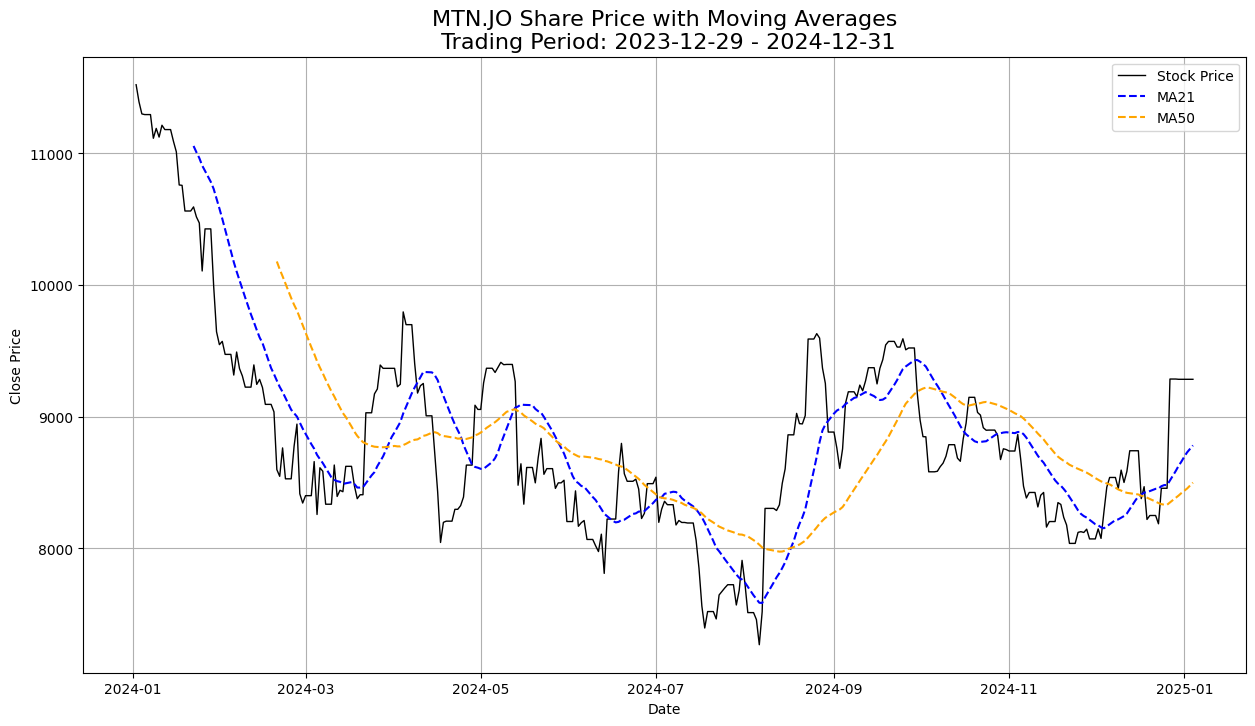

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a copy and set the 'Date' column as index for plotting
merged_df_plot = merged_df.copy()
merged_df_plot.set_index('Date', inplace=True)

# Calculate Moving Averages (if not already done in the previous steps)
merged_df_plot['MA21'] = merged_df_plot['Stock Price'].rolling(window=21).mean()
merged_df_plot['MA50'] = merged_df_plot['Stock Price'].rolling(window=50).mean()

# Plotting with Matplotlib
plt.figure(figsize=(15, 8))
plt.plot(merged_df_plot.index, merged_df_plot['Stock Price'], label='Stock Price', color='black', linewidth=1)
plt.plot(merged_df_plot.index, merged_df_plot['MA21'], label='MA21', color='blue', linestyle='--')
plt.plot(merged_df_plot.index, merged_df_plot['MA50'], label='MA50', color='orange', linestyle='--')

plt.title('MTN.JO Share Price with Moving Averages\n Trading Period: 2023-12-29 - 2024-12-31', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

###**Decomposition of the Closing Price**
Decomposition of the Closing Price data is broken down into three segments namely the trend,seasonality and the residuals. This is to allow for the STL Decomposition ('normalisation') to occur and then later performing the Augmented Dickey Fuller Test in order to test and adjust for stationarity in the data.

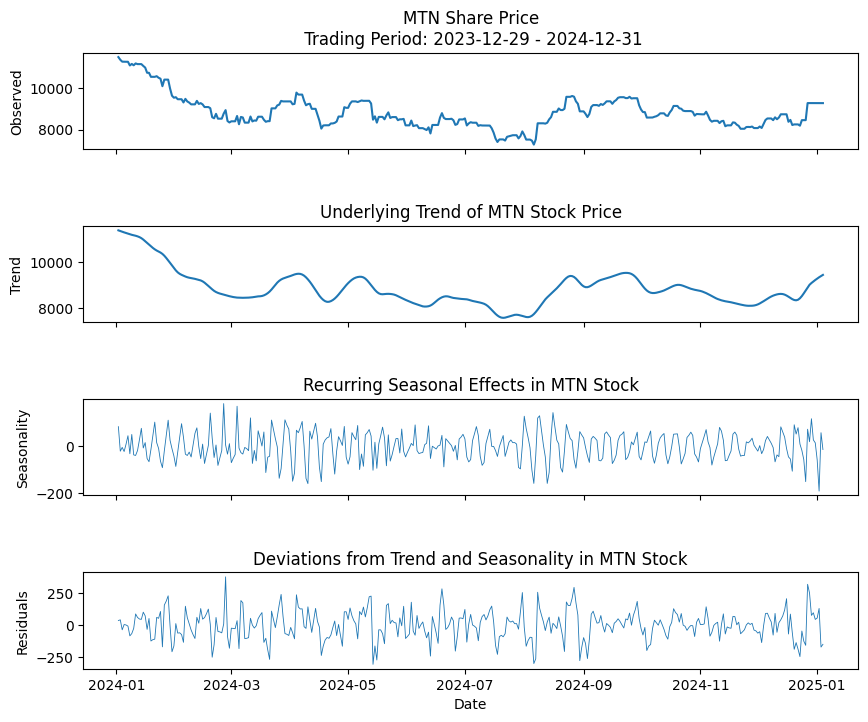

In [16]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
import pandas as pd

# Ensure merged_df is available and has 'Stock Price' column
# Drop leading NaN values from the 'Stock Price' column
# STL is sensitive to NaNs, especially at the beginning of the series
decomposition_data = merged_df.set_index('Date')['Stock Price'].dropna()

# Check if the data is sufficient after dropping NaNs
if len(decomposition_data) < 2 * 7: # STL requires at least two full periods
    print("Error: Not enough data points after dropping NaNs for decomposition with period 7.")
else:
    # Perform STL decomposition
    # For daily stock data, a 7-day period is appropriate for weekly seasonality
    decomposition = STL(decomposition_data, period=7).fit()

    # Plot the decomposition components
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10, 8))

    ax1.plot(decomposition.observed)
    ax1.set_ylabel('Observed')
    ax1.set_title('MTN Share Price\n Trading Period: 2023-12-29 - 2024-12-31')

    ax2.plot(decomposition.trend)
    ax2.set_ylabel('Trend')
    ax2.set_title('Underlying Trend of MTN Stock Price')

    ax3.plot(decomposition.seasonal, linewidth=0.6)
    ax3.set_ylabel('Seasonality')
    ax3.set_title('Recurring Seasonal Effects in MTN Stock')

    ax4.plot(decomposition.resid, linewidth=0.6)
    ax4.set_ylabel('Residuals')
    ax4.set_title('Deviations from Trend and Seasonality in MTN Stock')

    plt.subplots_adjust(hspace=0.8) # Adjust spacing between subplots
    plt.xlabel('Date') # Add xlabel to the last subplot
    plt.show()

###Visualising the Normalised Closing Price
Normalising the Closing Price data and visualising the normalised data with a 95% Confidence Interval and a rolling mean of 30 days this is against the original closing price prior to adjustments.

In [17]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files # Import files for downloading
import numpy as np # Import numpy for calculations

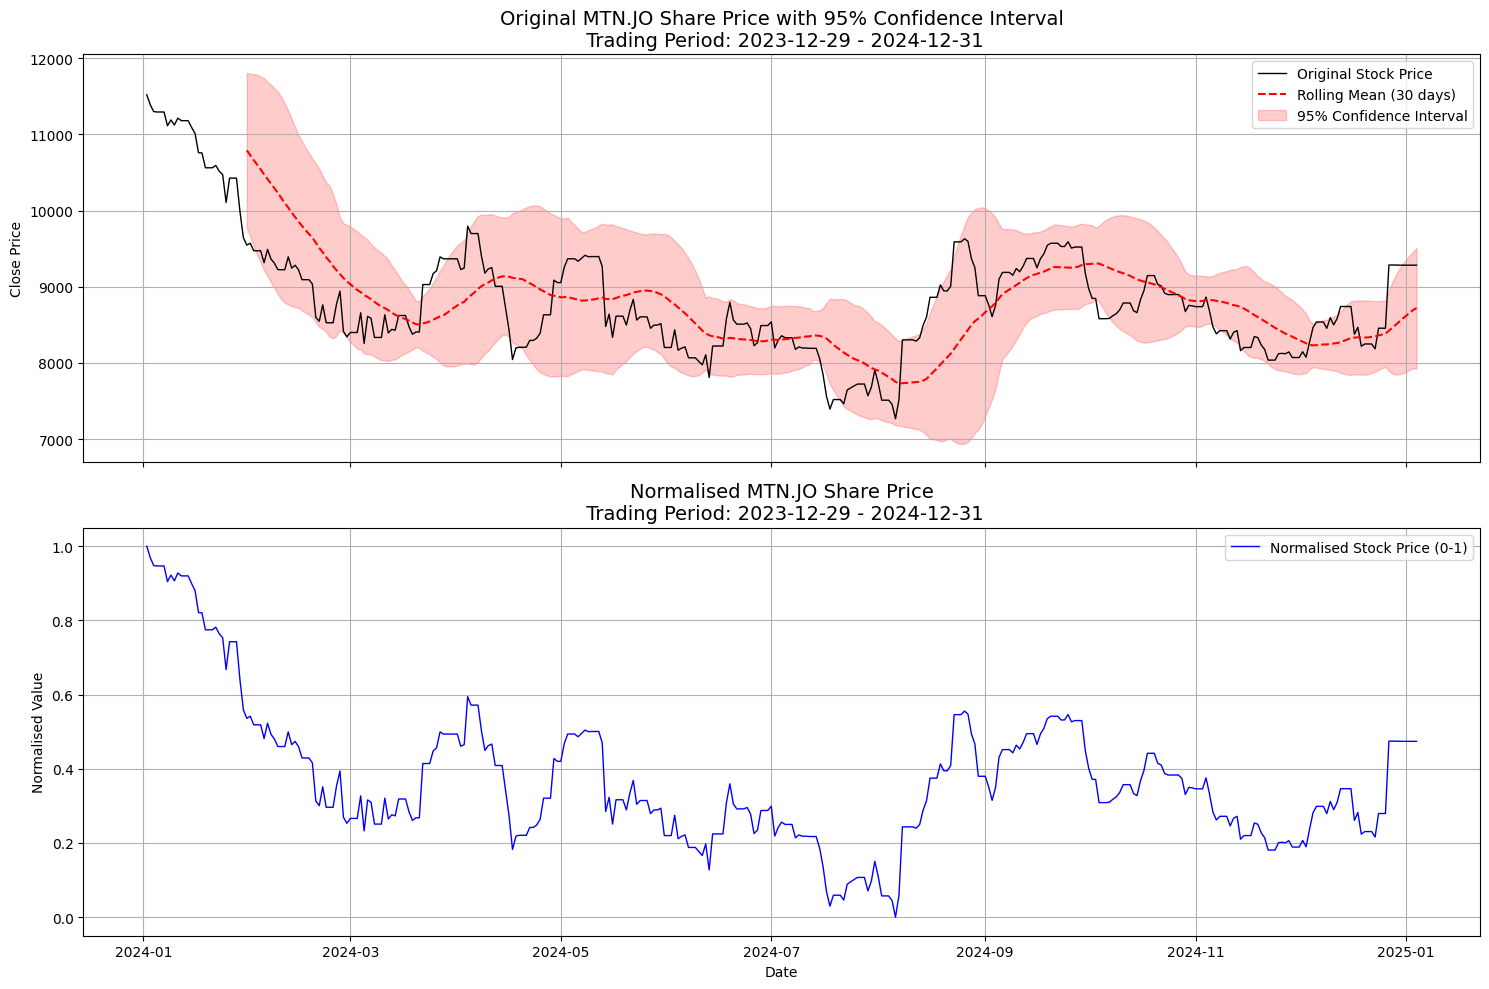

In [18]:
# Create a copy for normalisation and plotting
merged_df_norm = merged_df.copy()

# Set the 'Date' column as the index for plotting
merged_df_norm.set_index('Date', inplace=True)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Reshape the 'Stock Price' column to be 2D for the scaler
stock_price_reshaped = merged_df_norm['Stock Price'].values.reshape(-1, 1)

# Fit and transform the data
merged_df_norm['Stock Price Normalised'] = scaler.fit_transform(stock_price_reshaped)

# Calculate Rolling Mean and Standard Deviation for Confidence Interval
window_size = 30
merged_df_norm['Rolling_Mean'] = merged_df_norm['Stock Price'].rolling(window=window_size).mean()
merged_df_norm['Rolling_Std'] = merged_df_norm['Stock Price'].rolling(window=window_size).std()

# Calculate the 95% Confidence Interval
merged_df_norm['Upper_CI'] = merged_df_norm['Rolling_Mean'] + 1.96 * merged_df_norm['Rolling_Std']
merged_df_norm['Lower_CI'] = merged_df_norm['Rolling_Mean'] - 1.96 * merged_df_norm['Rolling_Std']


# Plotting the original and normalised stock price with Confidence Interval
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot original stock price with Rolling Mean and Confidence Interval
axes[0].plot(merged_df_norm.index, merged_df_norm['Stock Price'], label='Original Stock Price', color='black', linewidth=1)
axes[0].plot(merged_df_norm.index, merged_df_norm['Rolling_Mean'], label=f'Rolling Mean ({window_size} days)', color='red', linestyle='--')
axes[0].fill_between(merged_df_norm.index, merged_df_norm['Lower_CI'], merged_df_norm['Upper_CI'], color='red', alpha=0.2, label='95% Confidence Interval')

axes[0].set_title('Original MTN.JO Share Price with 95% Confidence Interval\n Trading Period: 2023-12-29 - 2024-12-31', fontsize=14)
axes[0].set_ylabel('Close Price')
axes[0].grid(True)
axes[0].legend()

# Plot normalised stock price
axes[1].plot(merged_df_norm.index, merged_df_norm['Stock Price Normalised'], label='Normalised Stock Price (0-1)', color='blue', linewidth=1)
axes[1].set_title('Normalised MTN.JO Share Price\n Trading Period: 2023-12-29 - 2024-12-31', fontsize=14)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Normalised Value')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()


###Augmented Dickey Fuller Test
Testing for stationarity after normalisation.

In [19]:
from statsmodels.tsa.stattools import adfuller

# Drop any leading NaN values
stock_price_series = merged_df['Stock Price'].dropna()

# Check if the series is empty after dropping NaNs
if stock_price_series.empty:
    print("Error: 'Stock Price' series is empty after removing NaN values. Cannot perform ADF test.")
else:
    # Performing the Dickey-Fuller test using the function 'adfuller'.
    result = adfuller(stock_price_series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Number of Lags Used: {result[2]}') # result[2] is the number of lags used
    print('Critical Values:') # printing the p value and all other corresponding critical values from the dataset.
    for key, value in result[4].items():
        print(f' {key}: {value}')

    # Interpretation of the p-value
    if result[1] <= 0.05:
        print("\nConclusion: The p-value is less than or equal to 0.05, so we reject the null hypothesis and conclude that,")
        print("The time series is likely stationary.")
    else:
        print("\nConclusion: The p-value is greater than 0.05, so we fail to reject the null hypothesis.")
        print("The time series is likely non-stationary.")

ADF Statistic: -3.4456442027724634
p-value: 0.00949785621283113
Number of Lags Used: 0
Critical Values:
 1%: -3.4482453822848496
 5%: -2.8694261442901396
 10%: -2.5709711770439507

Conclusion: The p-value is less than or equal to 0.05, so we reject the null hypothesis and conclude that,
The time series is likely stationary.


####Interpretation of ADF Test: Closing Price
The p-value of 0.0095 < p-value of 0.05, thus we reject the null hypothesis at a 5% level of significance and conclude that the Closing Price time series is stationary.

###**Google Trends Data Visualisation**
Visualising the Google Trends data for MTN.JO selected keywords. This is to assess the volatility of the keyword searches during the time period under evaluation.

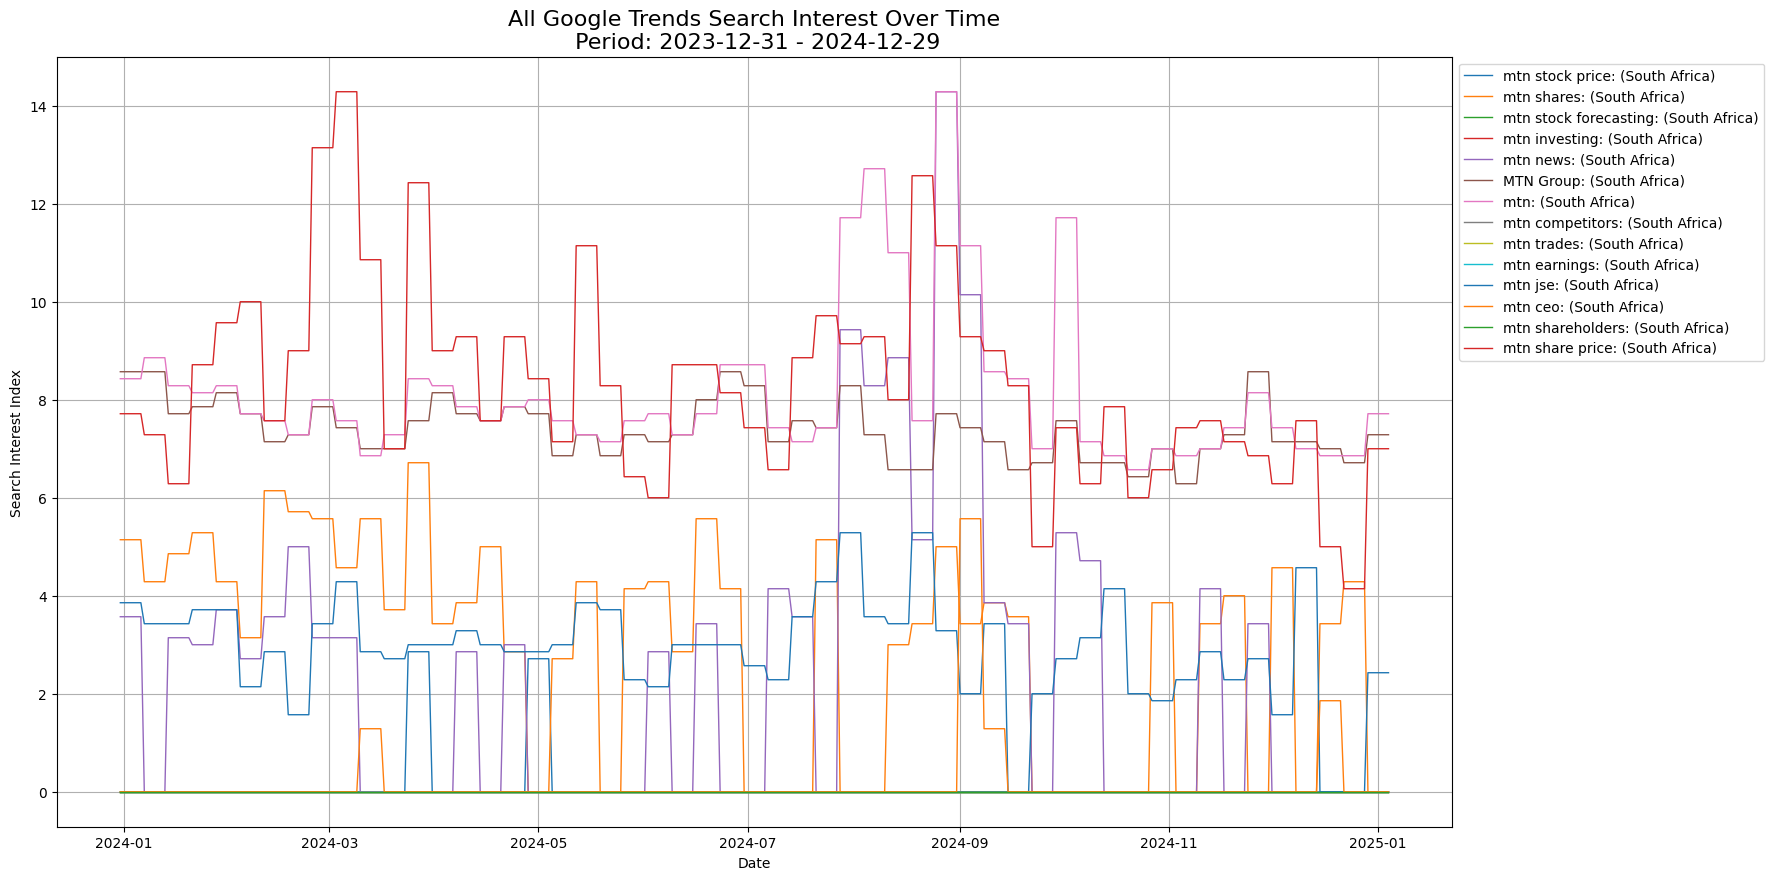

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Select all keyword columns from the DataFrame, excluding the 'Date' column
trends_columns_to_plot = [col for col in daily_df.columns if col != 'Date']

if not trends_columns_to_plot:
    print("No Google Trends columns found in the DataFrame to plot.")
else:
    # Set the 'Date' column as the index for plotting
    daily_df_plot = daily_df.copy()
    daily_df_plot.set_index('Date', inplace=True)

    plt.figure(figsize=(18, 10)) # Increase figure size for more columns

    for col in trends_columns_to_plot:
        plt.plot(daily_df_plot.index, daily_df_plot[col], label=col, linewidth=1)

    plt.title('All Google Trends Search Interest Over Time\n Period: 2023-12-31 - 2024-12-29', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Search Interest Index')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1)) # Move legend outside plot
    plt.grid(True)
    plt.show()

###Individual Keyword Visualisations with a 95% Confidence Interval

Plotting mtn stock price: (South Africa) with 95% Confidence Interval...


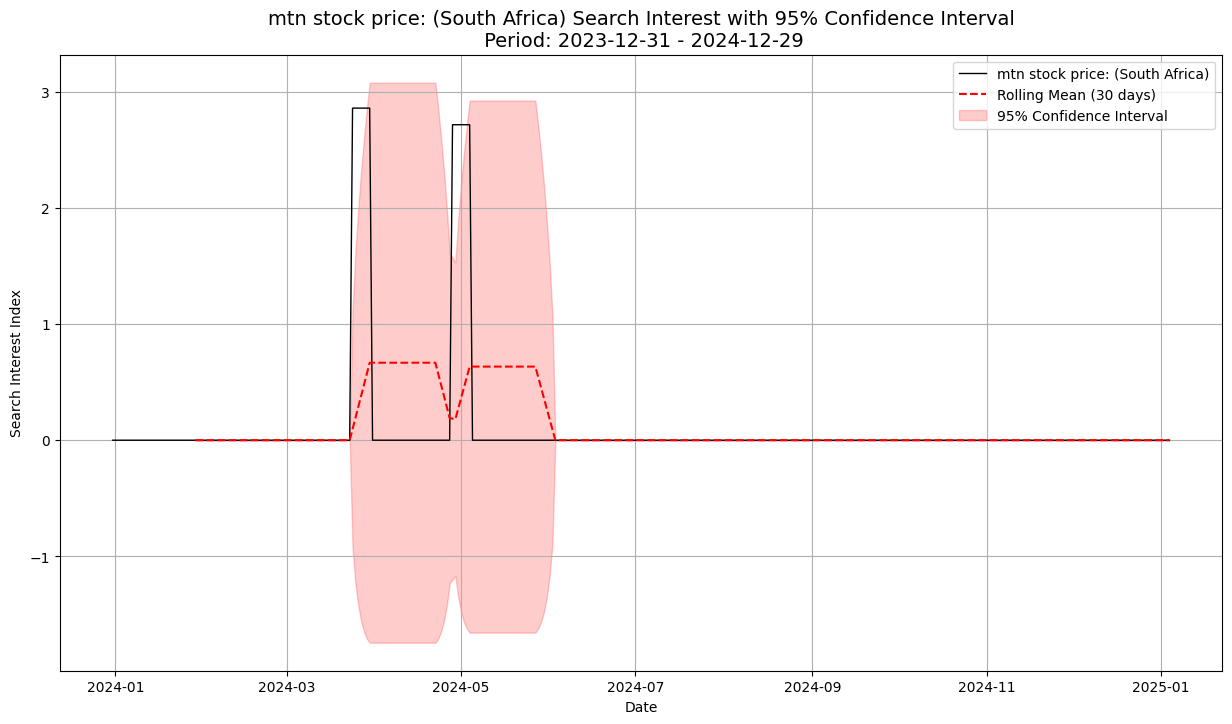

Plotting mtn shares: (South Africa) with 95% Confidence Interval...


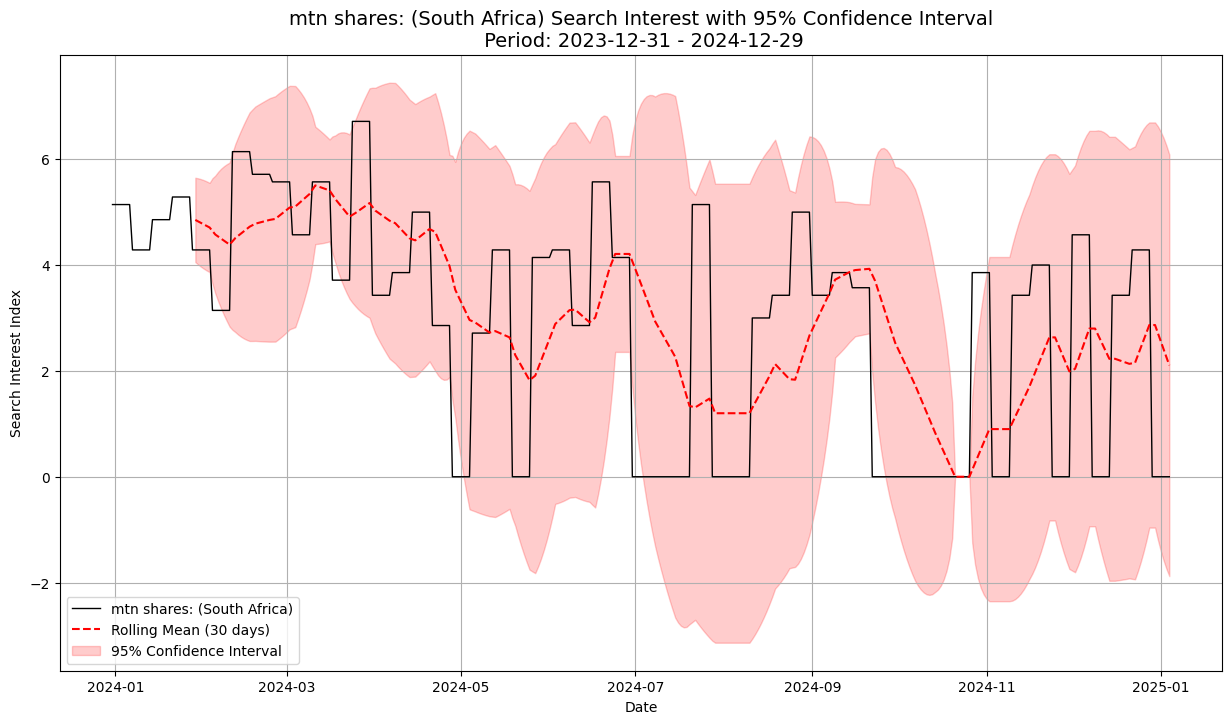

Plotting mtn stock forecasting: (South Africa) with 95% Confidence Interval...


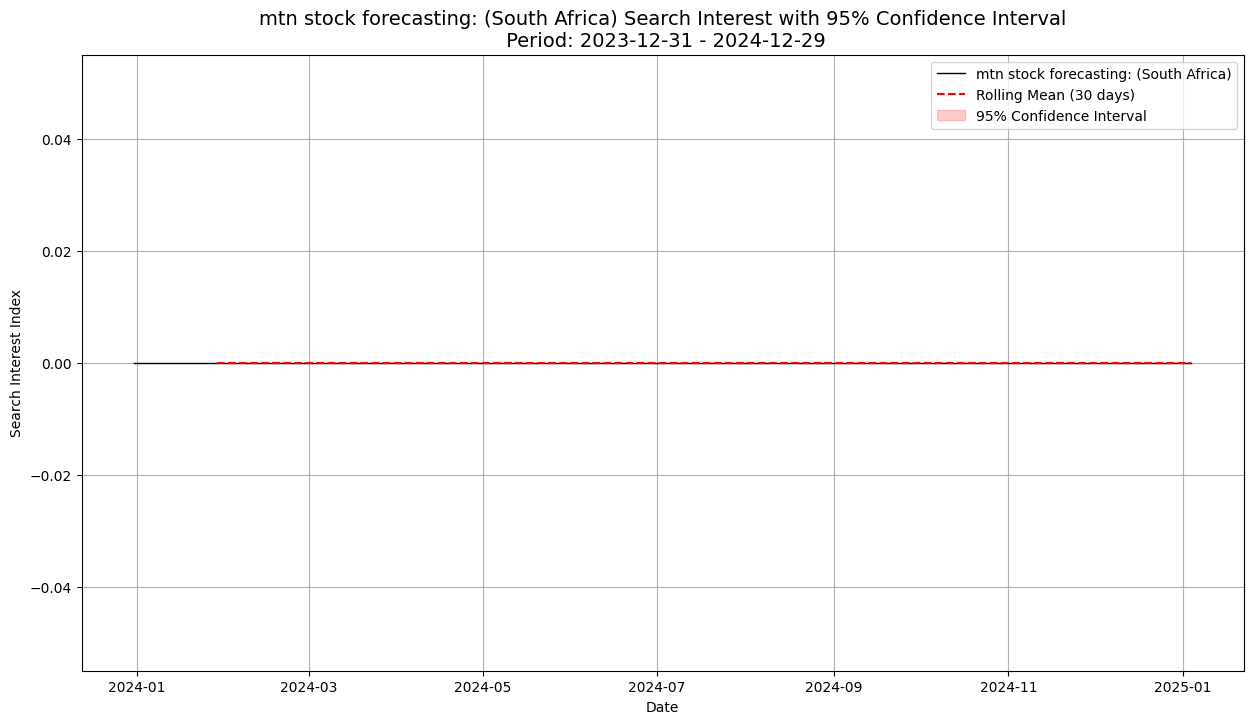

Plotting mtn investing: (South Africa) with 95% Confidence Interval...


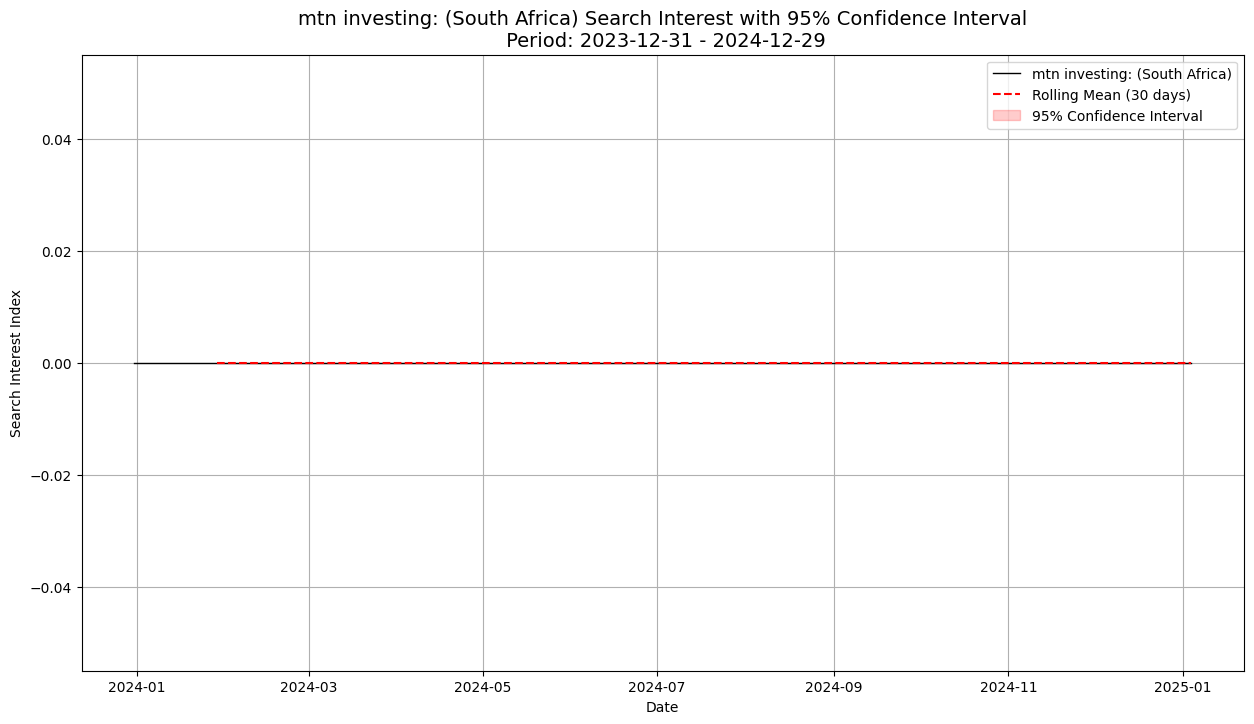

Plotting mtn news: (South Africa) with 95% Confidence Interval...


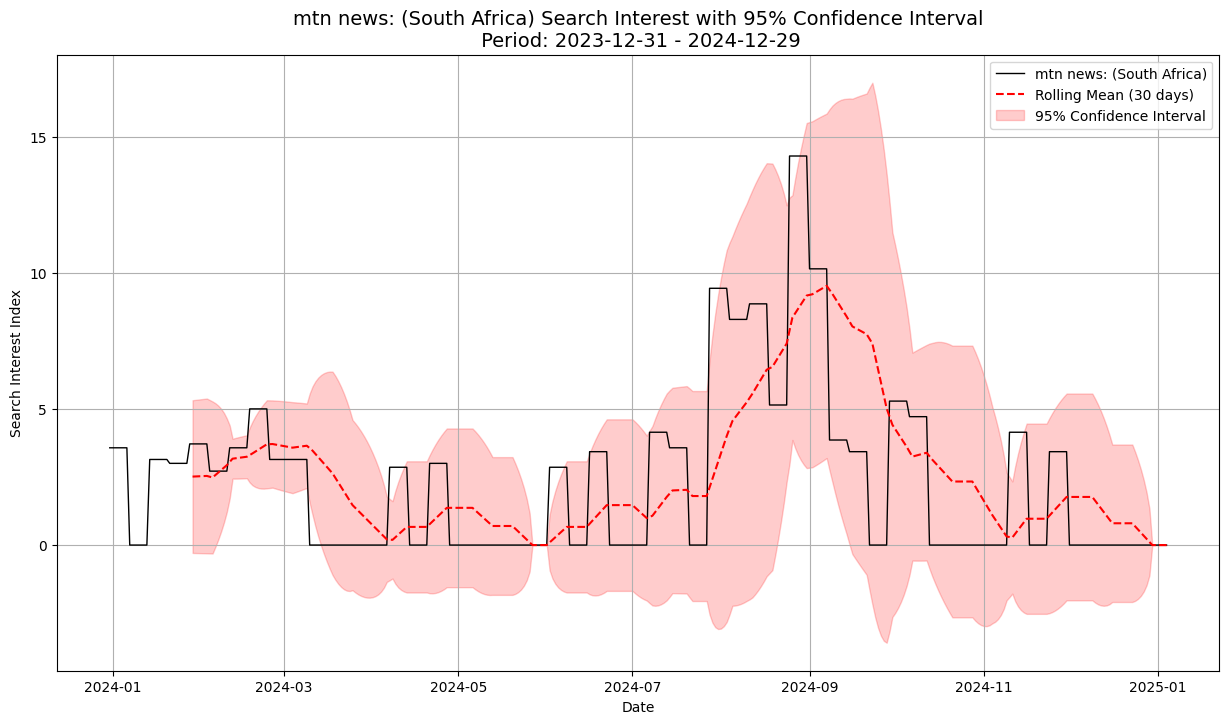

Plotting MTN Group: (South Africa) with 95% Confidence Interval...


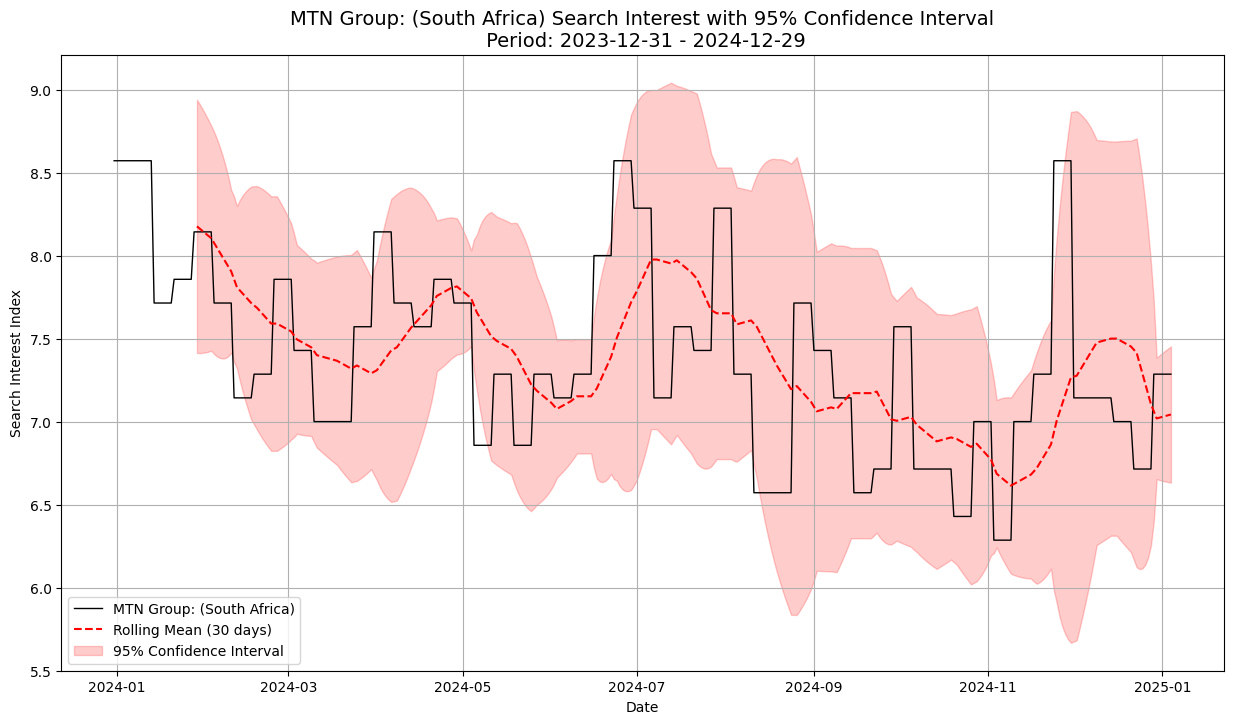

Plotting mtn: (South Africa) with 95% Confidence Interval...


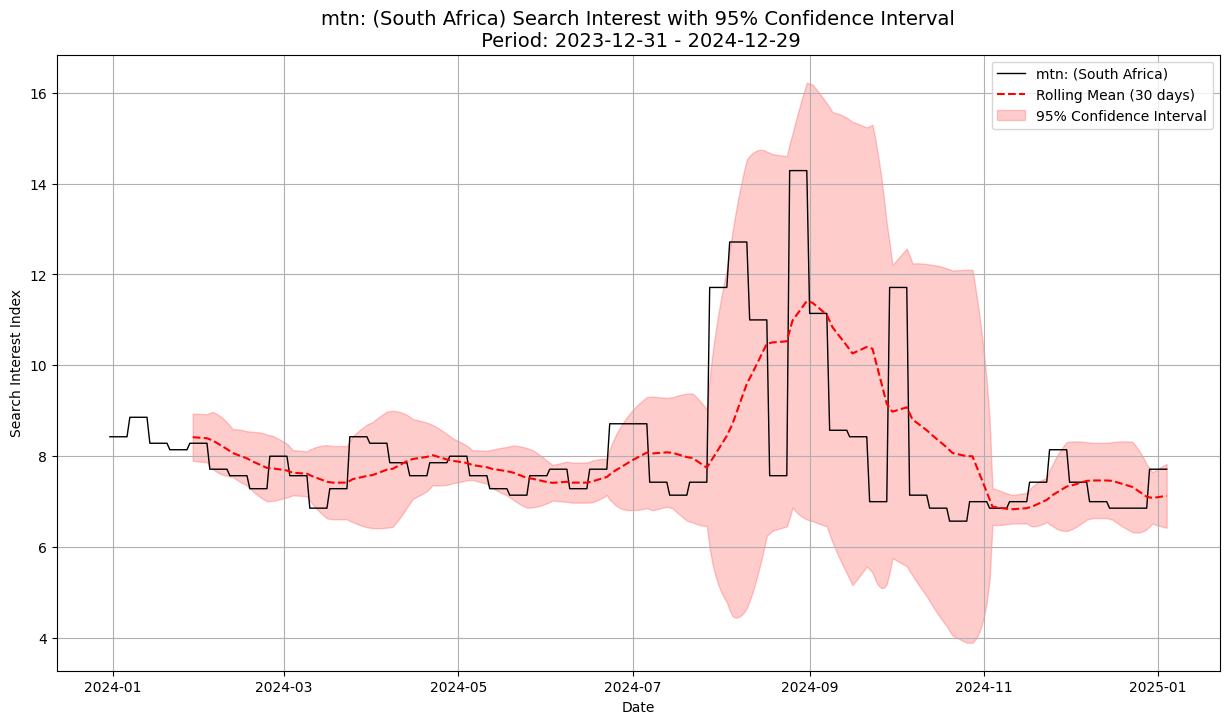

Plotting mtn competitors: (South Africa) with 95% Confidence Interval...


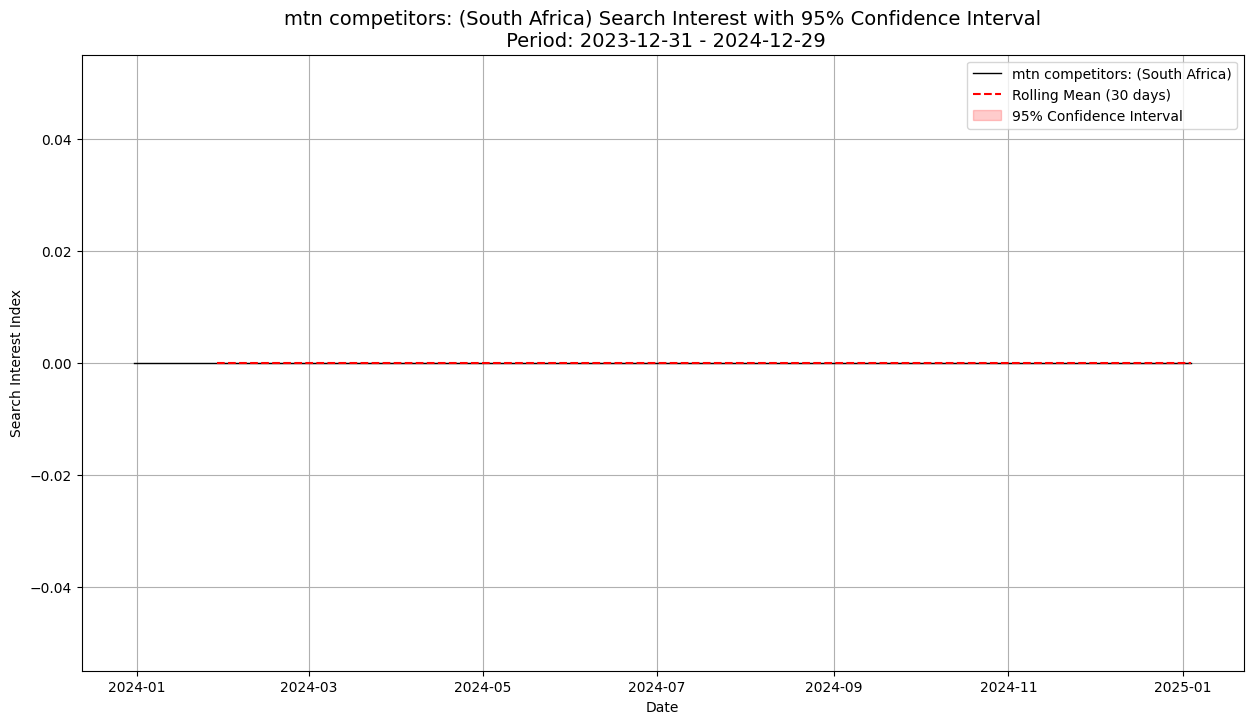

Plotting mtn trades: (South Africa) with 95% Confidence Interval...


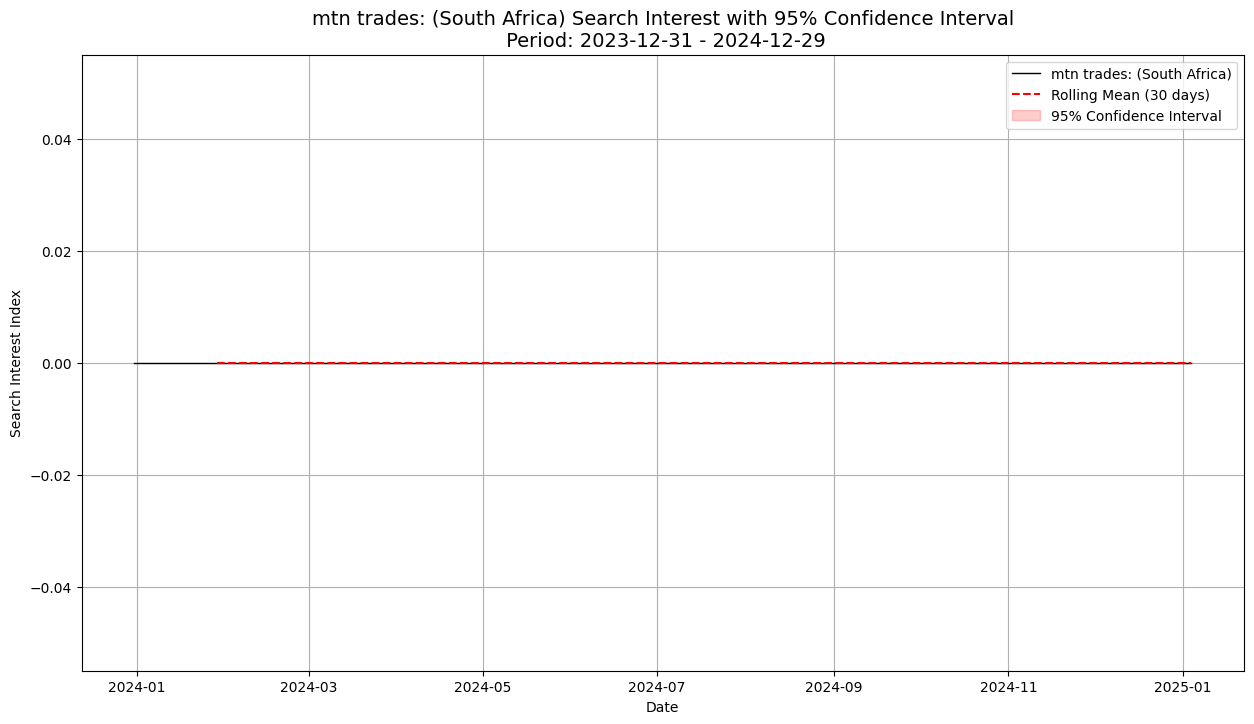

Plotting mtn earnings: (South Africa) with 95% Confidence Interval...


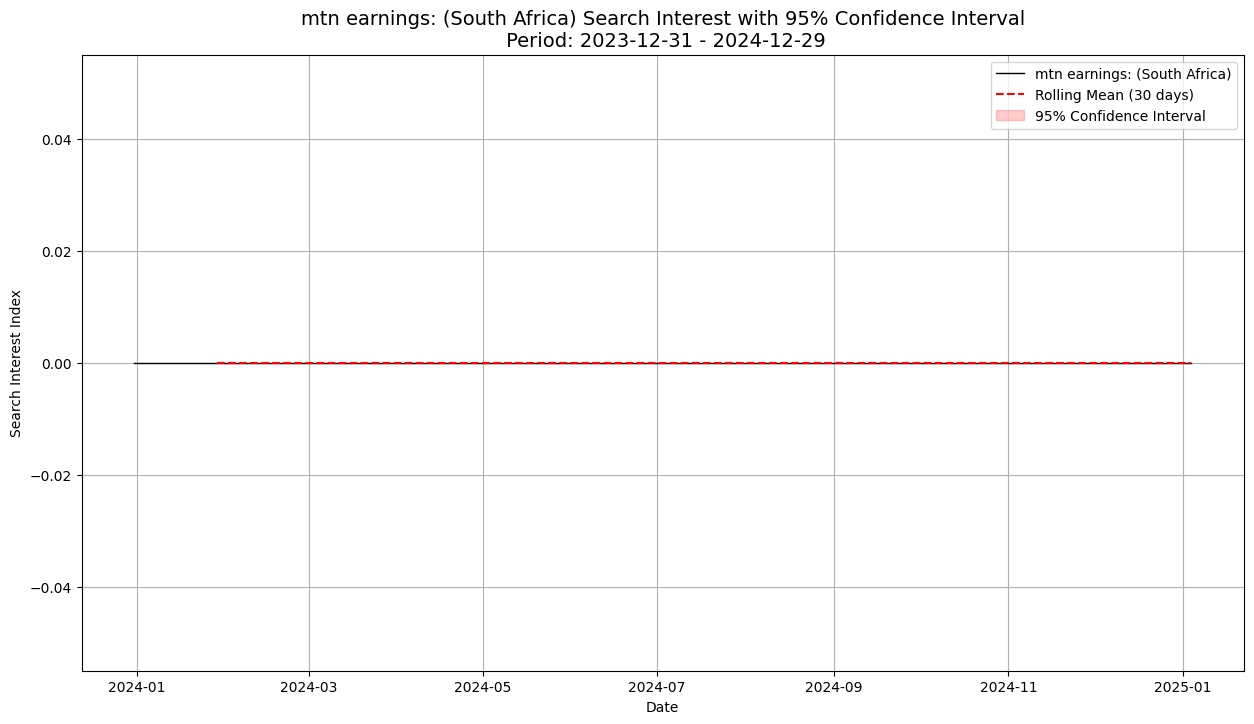

Plotting mtn jse: (South Africa) with 95% Confidence Interval...


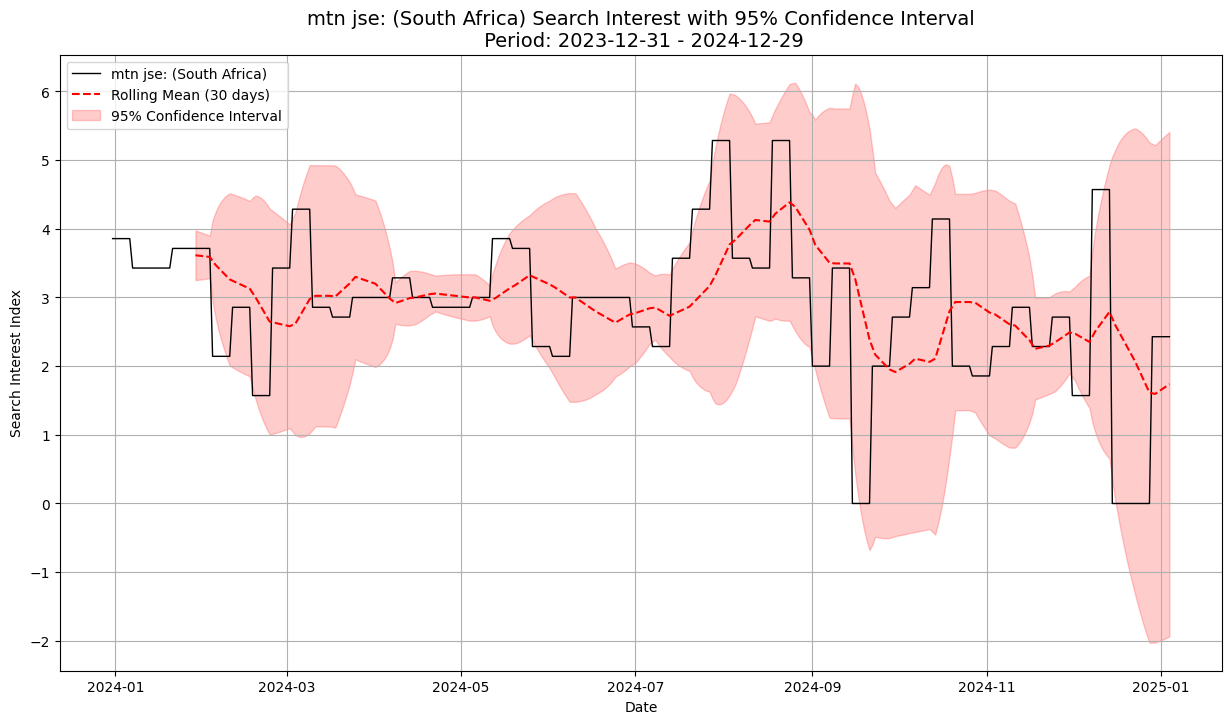

Plotting mtn ceo: (South Africa) with 95% Confidence Interval...


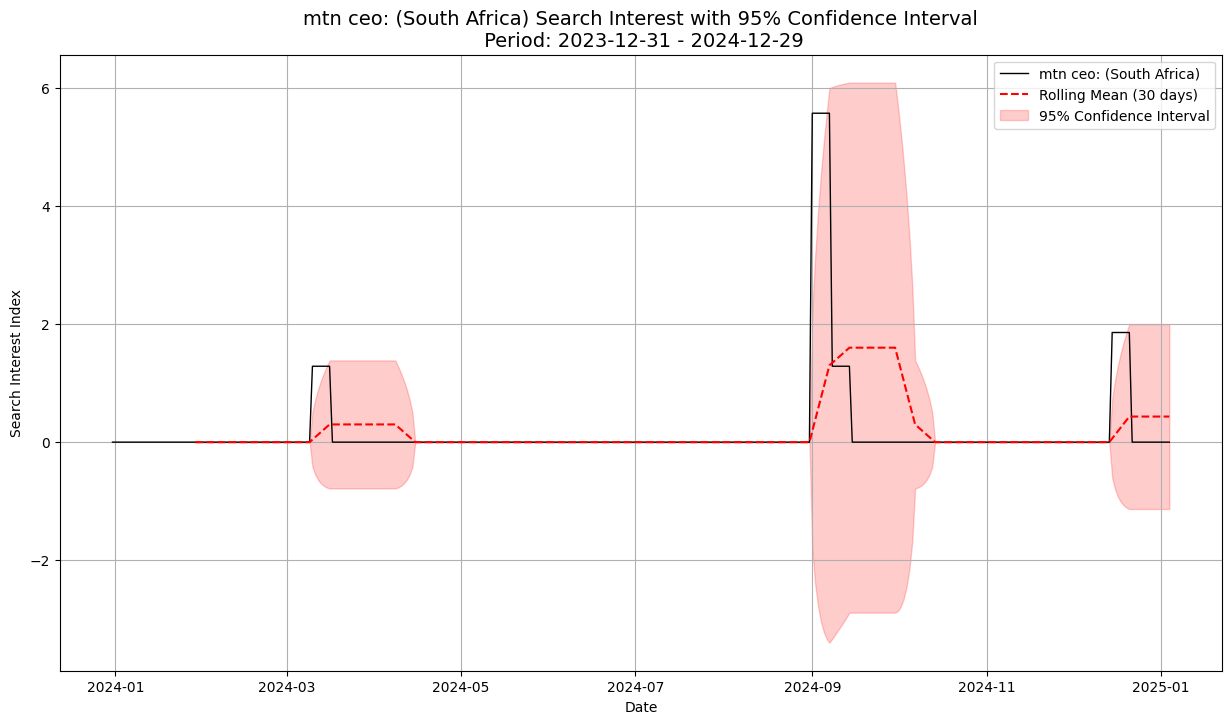

Plotting mtn shareholders: (South Africa) with 95% Confidence Interval...


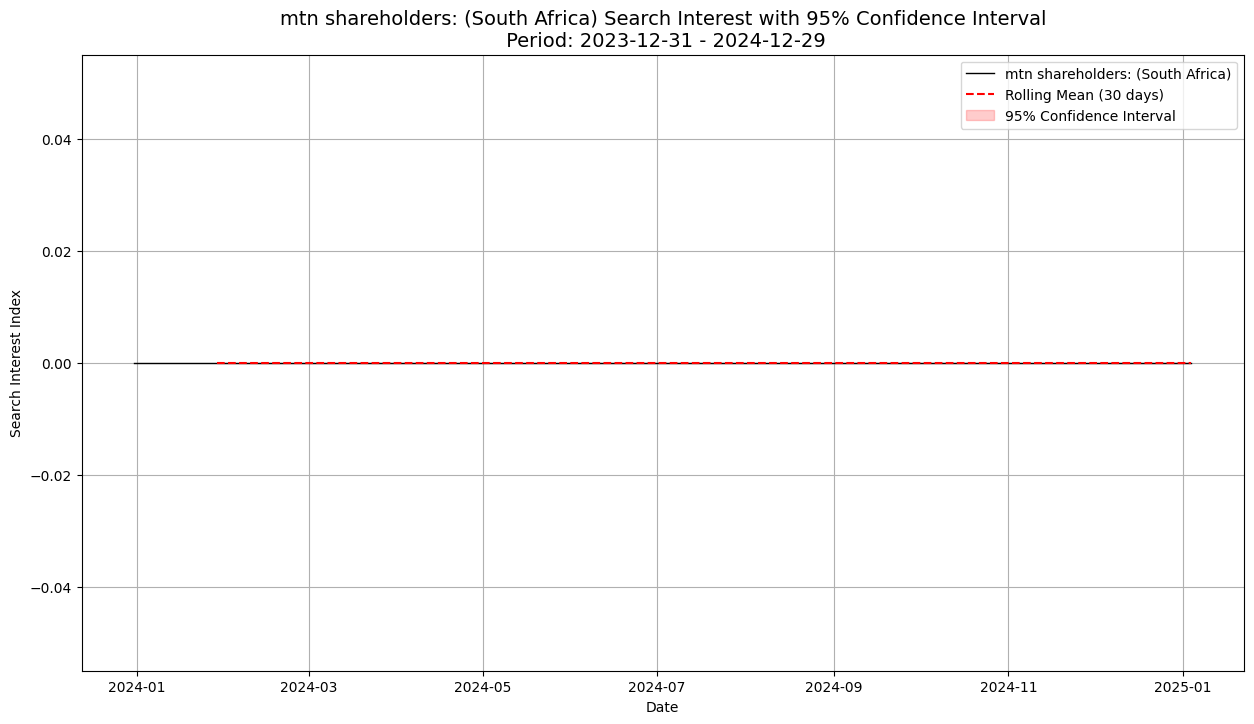

Plotting mtn share price: (South Africa) with 95% Confidence Interval...


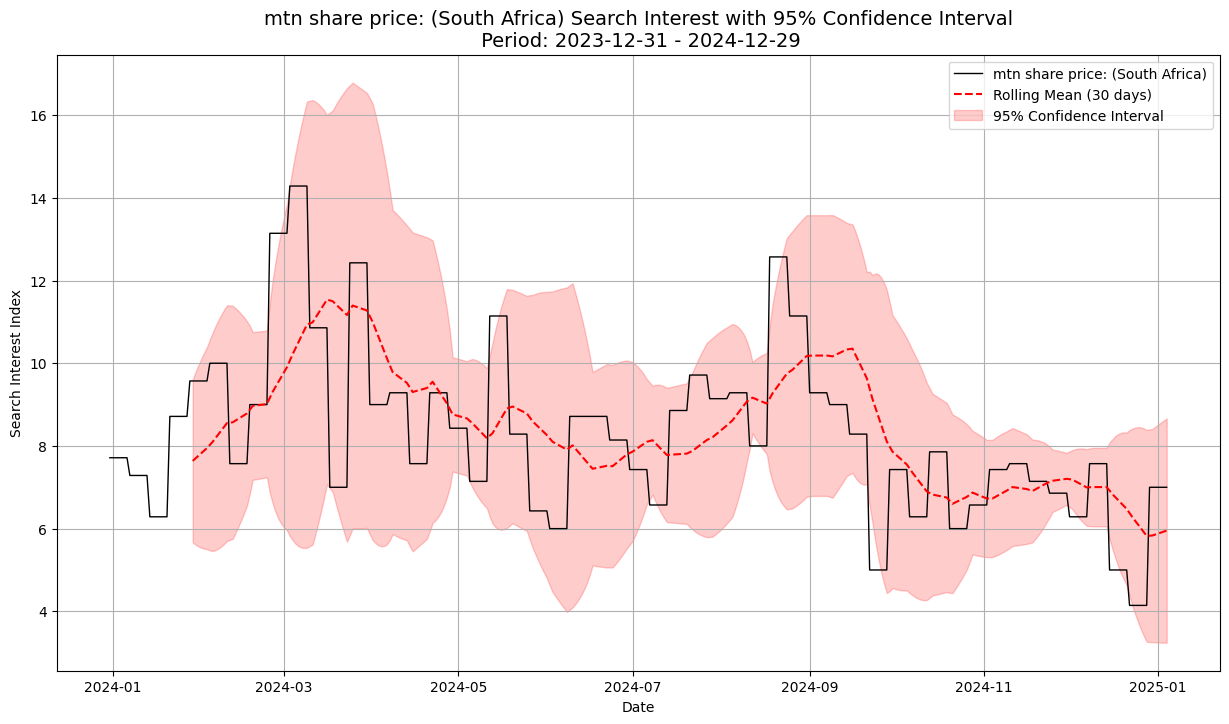

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming daily_df is available and contains the daily Google Trends data
# Select all keyword columns from the DataFrame, excluding the 'Date' column
trends_columns_to_plot_ci = [col for col in daily_df.columns if col != 'Date']

if not trends_columns_to_plot_ci:
    print("No Google Trends columns found in the DataFrame to plot with CI.")
else:
    # Set the 'Date' column as the index for plotting
    daily_df_indexed_ci = daily_df.copy()
    daily_df_indexed_ci.set_index('Date', inplace=True)

    window_size_trends = 30 # Define window size for rolling calculations

    for col in trends_columns_to_plot_ci:
        print(f"Plotting {col} with 95% Confidence Interval...")

        # Calculate Rolling Mean and Standard Deviation for Confidence Interval
        daily_df_indexed_ci['Rolling_Mean'] = daily_df_indexed_ci[col].rolling(window=window_size_trends).mean()
        daily_df_indexed_ci['Rolling_Std'] = daily_df_indexed_ci[col].rolling(window=window_size_trends).std()

        # Calculate the 95% Confidence Interval
        # Using t-distribution for smaller samples, but z is common for large data
        # For simplicity and consistency with the stock price plot, we'll use z (1.96)
        daily_df_indexed_ci['Upper_CI'] = daily_df_indexed_ci['Rolling_Mean'] + 1.96 * daily_df_indexed_ci['Rolling_Std']
        daily_df_indexed_ci['Lower_CI'] = daily_df_indexed_ci['Rolling_Mean'] - 1.96 * daily_df_indexed_ci['Rolling_Std']

        # Plotting
        plt.figure(figsize=(15, 8))
        plt.plot(daily_df_indexed_ci.index, daily_df_indexed_ci[col], label=col, color='black', linewidth=1)
        plt.plot(daily_df_indexed_ci.index, daily_df_indexed_ci['Rolling_Mean'], label=f'Rolling Mean ({window_size_trends} days)', color='red', linestyle='--')
        plt.fill_between(daily_df_indexed_ci.index, daily_df_indexed_ci['Lower_CI'], daily_df_indexed_ci['Upper_CI'], color='red', alpha=0.2, label='95% Confidence Interval')

        plt.title(f'{col} Search Interest with 95% Confidence Interval\n Period: 2023-12-31 - 2024-12-29', fontsize=14)
        plt.xlabel('Date')
        plt.ylabel('Search Interest Index')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Clean up the temporary rolling columns for the next iteration
        daily_df_indexed_ci.drop(columns=['Rolling_Mean', 'Rolling_Std', 'Upper_CI', 'Lower_CI'], inplace=True)

###**Decomposition of Keywords**
Decomposition of the Google Trends data into three segments namely the trend,seasonality and the residuals. This is to allow for the STL Decomposition ('normalisation') to occur and then later performing the Augmented Dickey Fuller Test in order to test and adjust for stationarity in the data.

Performing STL decomposition for: mtn stock price: (South Africa)


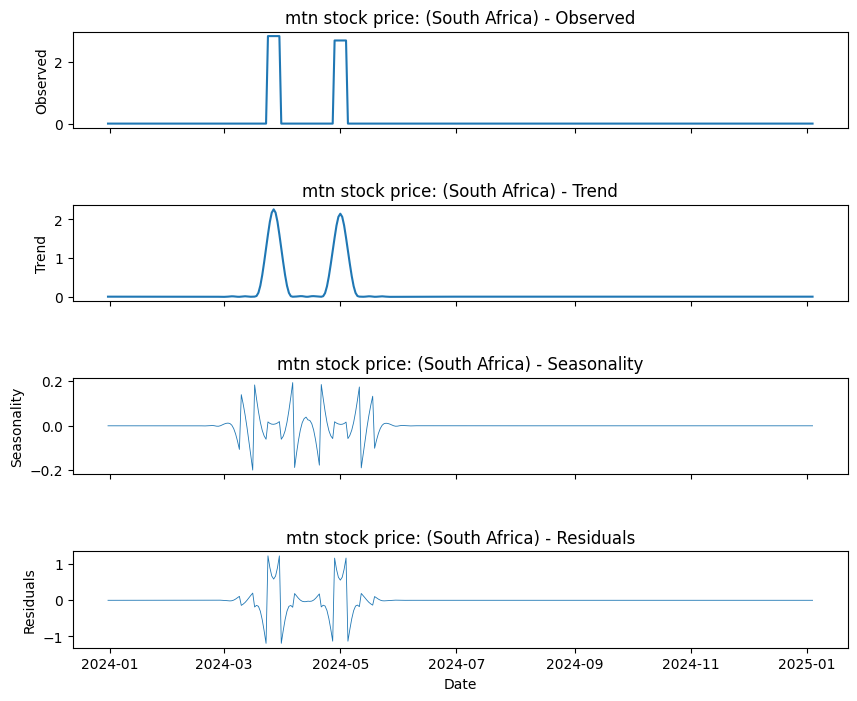

Performing STL decomposition for: mtn shares: (South Africa)


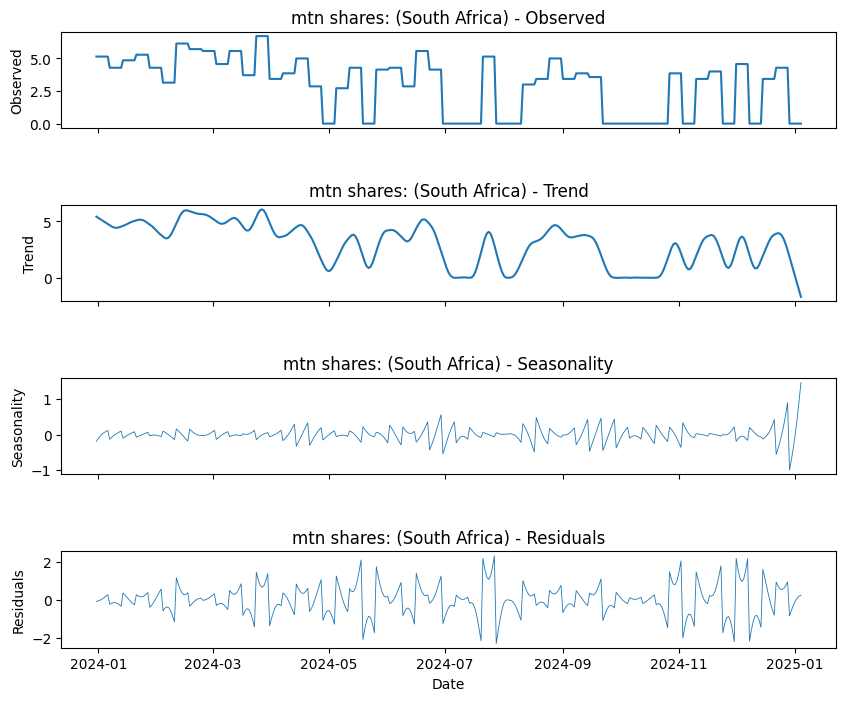

Performing STL decomposition for: mtn stock forecasting: (South Africa)


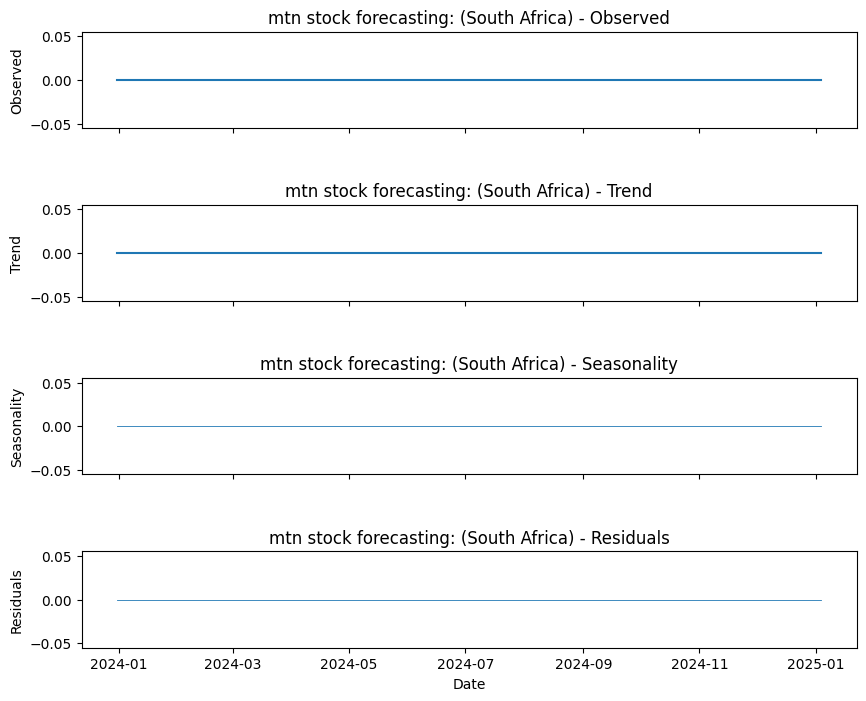

Performing STL decomposition for: mtn investing: (South Africa)


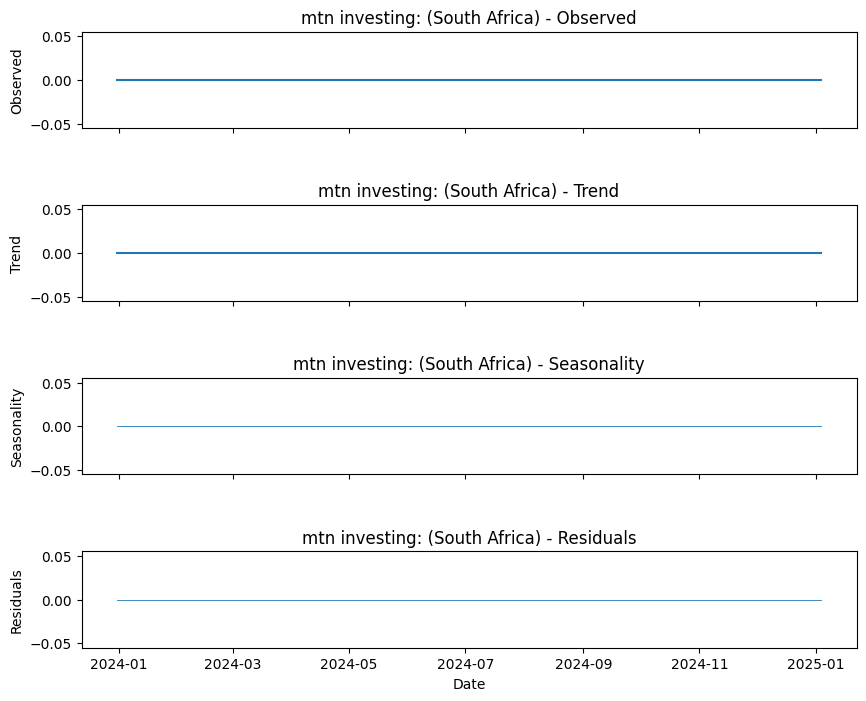

Performing STL decomposition for: mtn news: (South Africa)


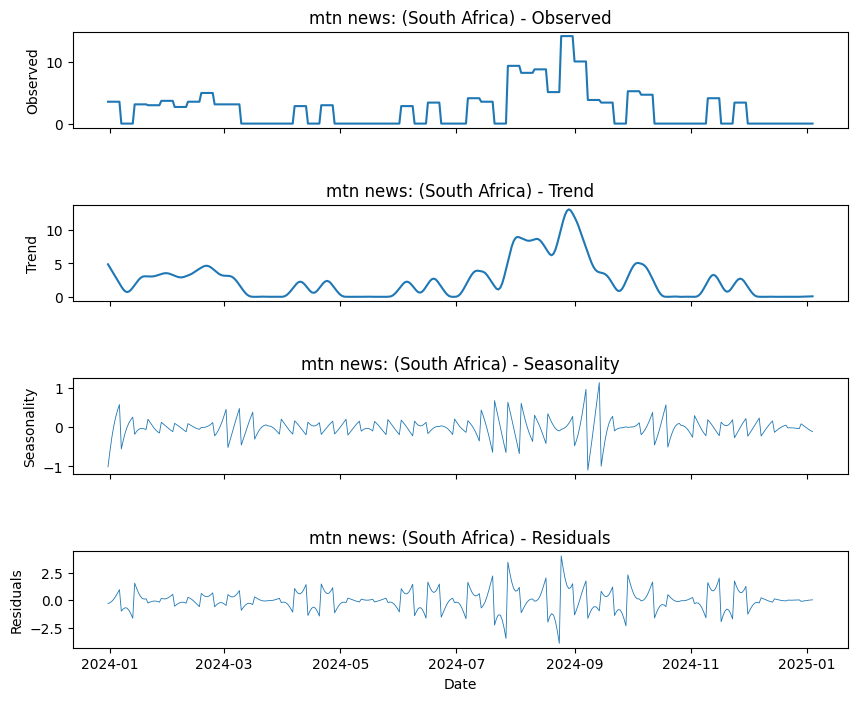

Performing STL decomposition for: MTN Group: (South Africa)


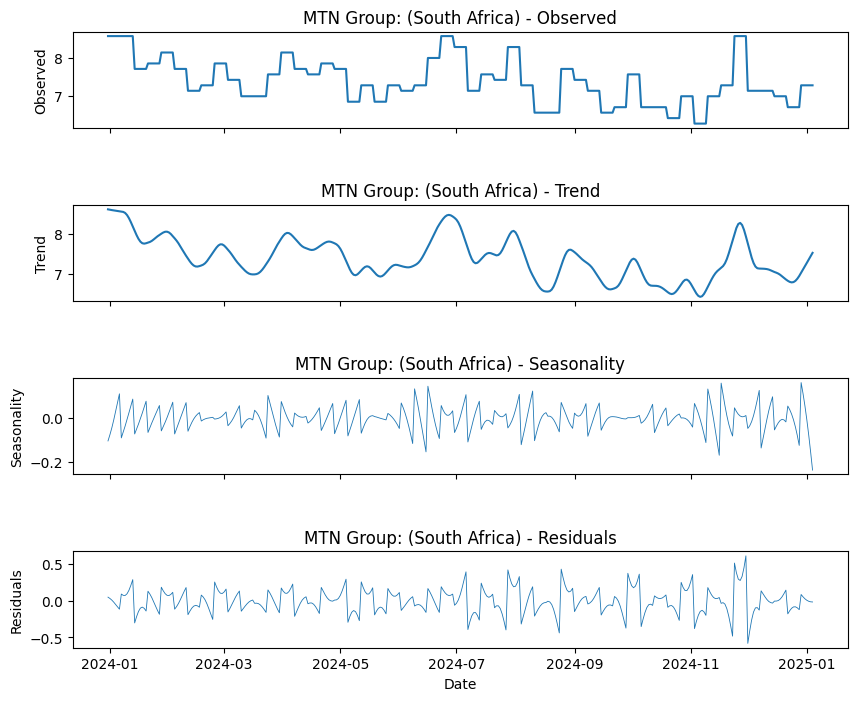

Performing STL decomposition for: mtn: (South Africa)


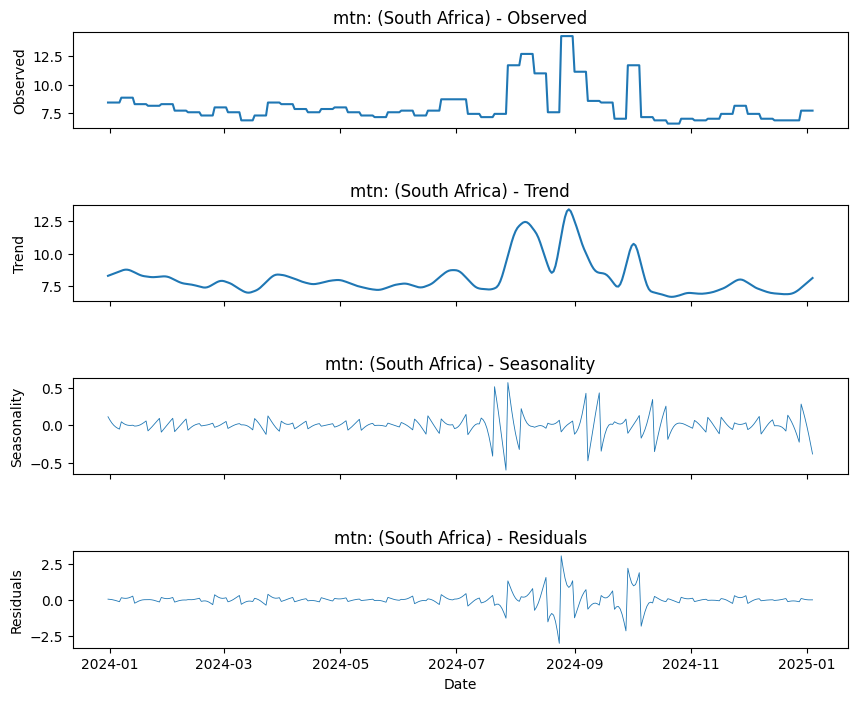

Performing STL decomposition for: mtn competitors: (South Africa)


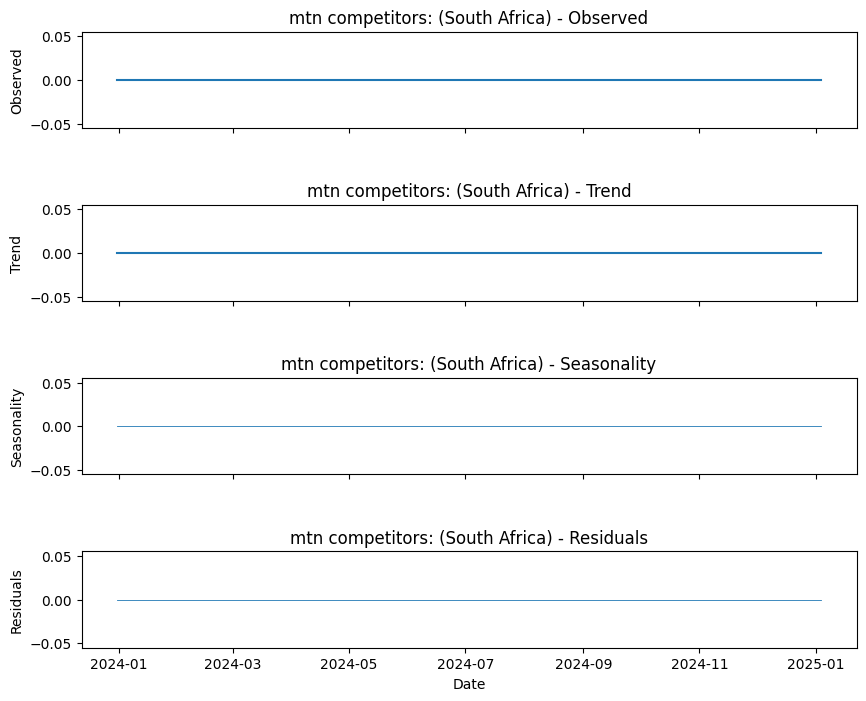

Performing STL decomposition for: mtn trades: (South Africa)


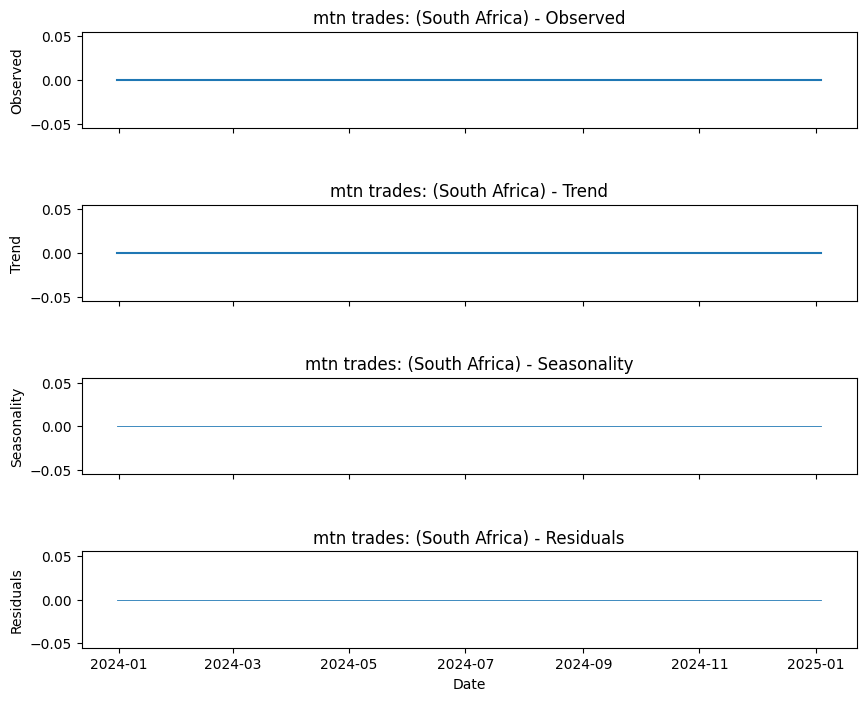

Performing STL decomposition for: mtn earnings: (South Africa)


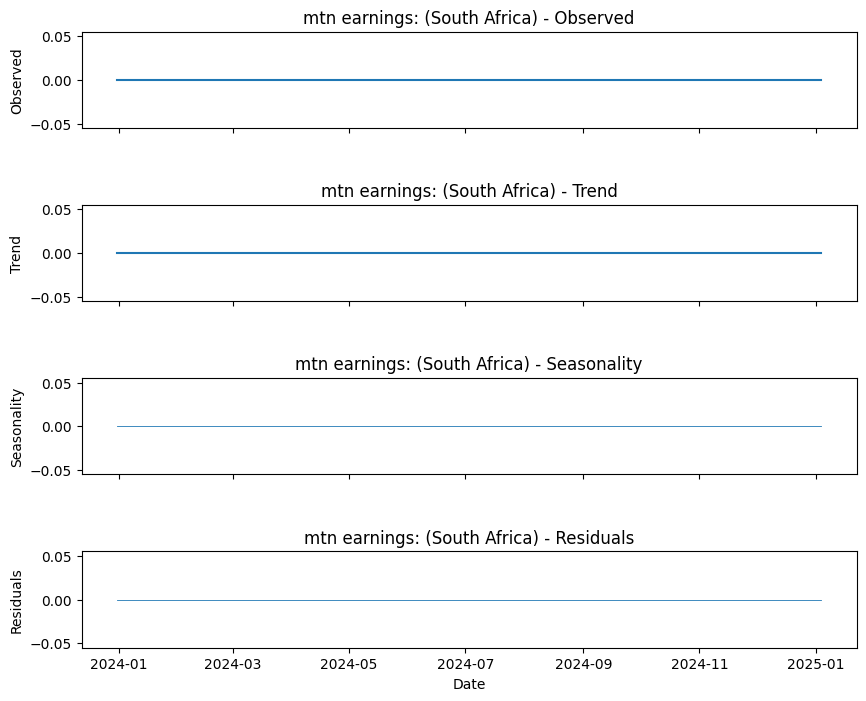

Performing STL decomposition for: mtn jse: (South Africa)


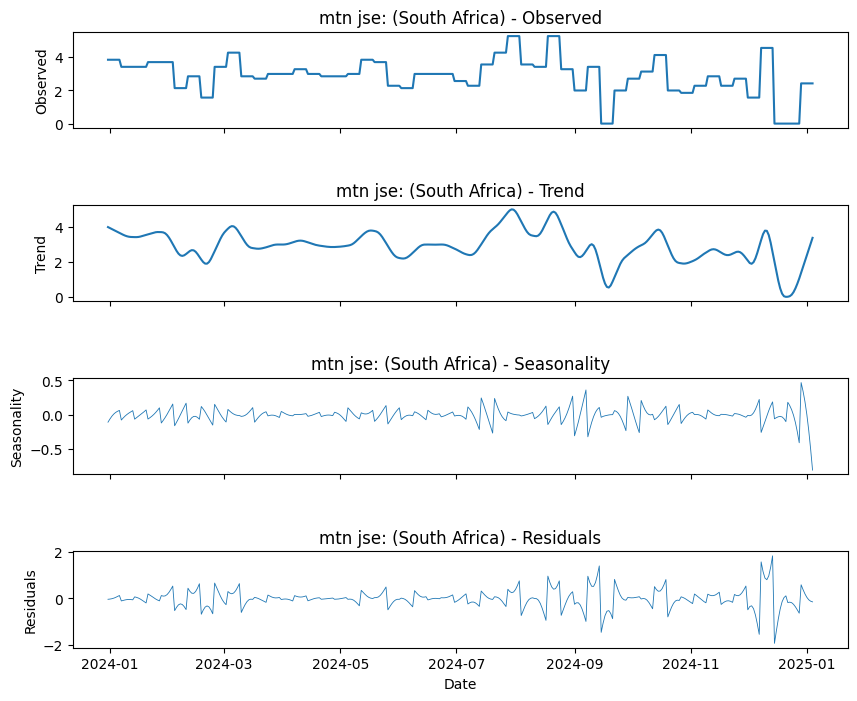

Performing STL decomposition for: mtn ceo: (South Africa)


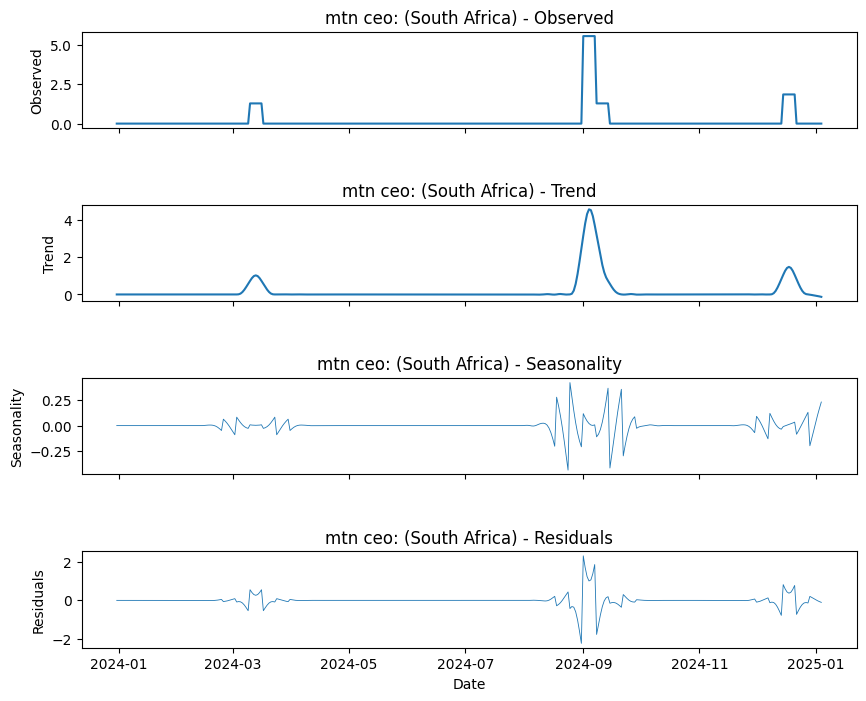

Performing STL decomposition for: mtn shareholders: (South Africa)


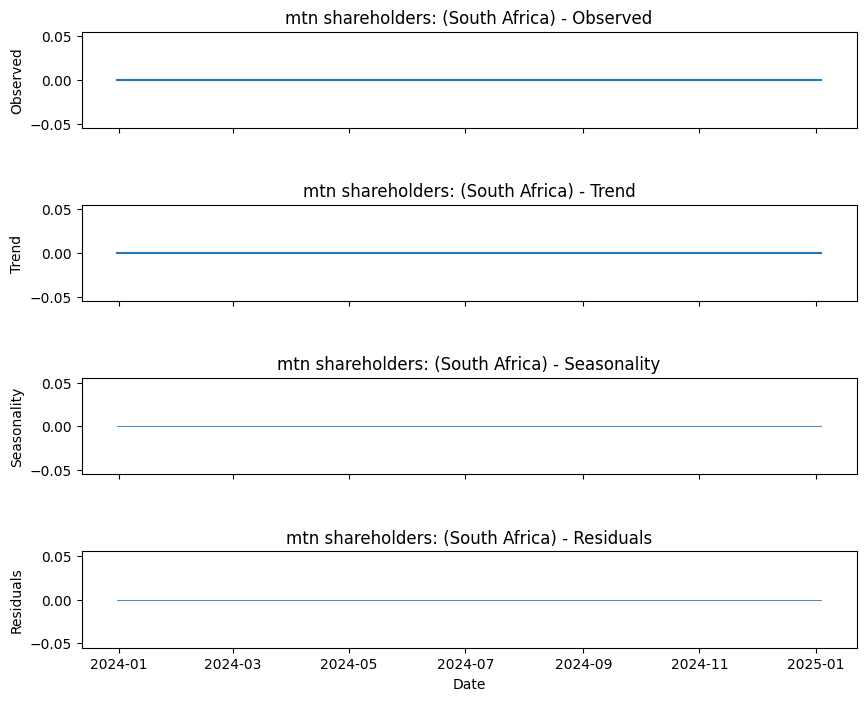

Performing STL decomposition for: mtn share price: (South Africa)


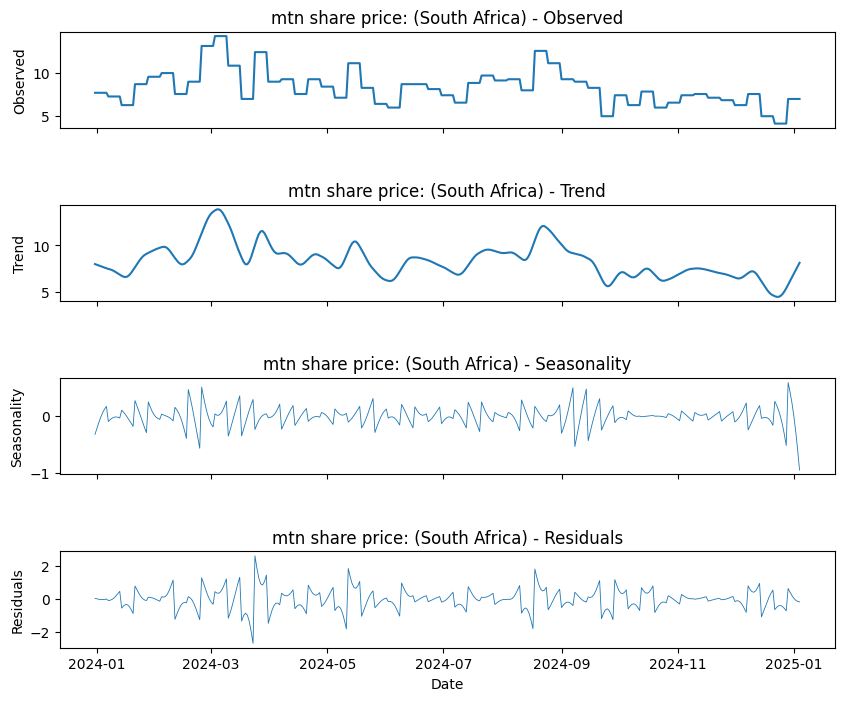

In [22]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
import pandas as pd

# Assuming daily_df is available and contains the daily Google Trends data
# Select all keyword columns from the DataFrame, excluding the 'Date' column
trends_columns_to_decompose = [col for col in daily_df.columns if col != 'Date']

if not trends_columns_to_decompose:
    print("No Google Trends columns found in the DataFrame to decompose.")
else:
    # Set the 'Date' column as the index for decomposition
    daily_df_indexed = daily_df.copy()
    daily_df_indexed.set_index('Date', inplace=True)

    for col in trends_columns_to_decompose:
        print(f"Performing STL decomposition for: {col}")

        # Select the individual keyword series and drop any NaN values
        keyword_series = daily_df_indexed[col].dropna()

        if len(keyword_series) < 2 * 7: # STL requires at least two full periods (period=7 for daily data)
             print(f"  Skipping decomposition for {col}: Not enough data points after dropping NaNs.")
             continue

        try:
            # Perform STL decomposition
            # Using a 7-day period for daily seasonality
            decomposition = STL(keyword_series, period=7).fit()

            # Plot the decomposition components
            fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10, 8))

            ax1.plot(decomposition.observed)
            ax1.set_ylabel('Observed')
            ax1.set_title(f'{col} - Observed')

            ax2.plot(decomposition.trend)
            ax2.set_ylabel('Trend')
            ax2.set_title(f'{col} - Trend')

            ax3.plot(decomposition.seasonal, linewidth=0.6)
            ax3.set_ylabel('Seasonality')
            ax3.set_title(f'{col} - Seasonality')

            ax4.plot(decomposition.resid, linewidth=0.6)
            ax4.set_ylabel('Residuals')
            ax4.set_title(f'{col} - Residuals')

            plt.subplots_adjust(hspace=0.8) # Adjust spacing between subplots
            plt.xlabel('Date') # Add xlabel to the last subplot
            plt.show()

        except Exception as e:
            print(f"  Error performing decomposition for {col}: {e}")

###**Normalising the Trends Data**

###**Stimulating the Cleaned DataFrames**

In [23]:
import pandas as pd
import numpy as np

# 1. Simulate Cleaned Yahoo Finance DataFrame...
# ...This DataFrame has a continuous daily date range with no weekend gaps.
date_range = pd.date_range(start='2023-12-28', end='2024-12-31', freq='D')
yahoo_cleaned_df = pd.DataFrame(index=date_range)
yahoo_cleaned_df['Close'] = 100 + 5 * np.sin(np.arange(len(date_range)) / 20) + np.random.normal(0, 1, len(date_range))

print("Simulated Cleaned Yahoo Finance Data:")
print(yahoo_cleaned_df.head())
print("-" * 50)

# 2. Simulate Cleaned Google Trends DataFrame...
# ...This DataFrame also has a continuous daily date range and is normalised.
trends_data = {
    'MTN stock price': 50 + 10 * np.sin(np.arange(len(date_range)) / 25) + np.random.normal(0, 5, len(date_range)),
    'Vodacom share price': 45 + 8 * np.sin(np.arange(len(date_range)) / 22) + np.random.normal(0, 4, len(date_range))
}
google_trends_df = pd.DataFrame(trends_data, index=date_range)



Simulated Cleaned Yahoo Finance Data:
                 Close
2023-12-28   99.249655
2023-12-29   99.277926
2023-12-30  100.233665
2023-12-31  100.203282
2024-01-01  102.143960
--------------------------------------------------


###**Normalising The Trends Data**

In [24]:
# Normalise the trends data (0 to 1 scale)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
google_trends_df_normalised = pd.DataFrame(scaler.fit_transform(google_trends_df), columns=google_trends_df.columns, index=google_trends_df.index)

print("Simulated Normalised Google Trends Data:")
print(google_trends_df_normalised.head())

Simulated Normalised Google Trends Data:
            MTN stock price  Vodacom share price
2023-12-28         0.616379             0.643265
2023-12-29         0.378147             0.382192
2023-12-30         0.381081             0.429743
2023-12-31         0.600240             0.602241
2024-01-01         0.538235             0.496791


###Augmented Dickey Fuller Test on the Trends Data

In [25]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# Assuming daily_df is available and contains the daily Google Trends data
# Select all keyword columns from the DataFrame, excluding the 'Date' column
trends_columns_to_test = [col for col in daily_df.columns if col != 'Date']

if not trends_columns_to_test:
    print("No Google Trends columns found in the DataFrame to test.")
else:
    # Set the 'Date' column as the index for testing
    daily_df_indexed = daily_df.copy()
    daily_df_indexed.set_index('Date', inplace=True)

    print("Performing Augmented Dickey-Fuller (ADF) test on Google Trends data:")
    print("-" * 60)

    for col in trends_columns_to_test:
        print(f"Testing stationarity for: {col}")

        # Select the individual keyword series and drop any NaN values
        keyword_series = daily_df_indexed[col].dropna()

        if keyword_series.empty:
            print(f"  Skipping test for {col}: Series is empty after dropping NaNs.")
            continue

        try:
            # Perform the Dickey-Fuller test
            result = adfuller(keyword_series, autolag='AIC')

            print(f'  ADF Statistic: {result[0]:.4f}')
            print(f'  p-value: {result[1]:.4f}')
            print(f'  Number of Lags Used: {result[2]}')
            print('  Critical Values:')
            for key, value in result[4].items():
                print(f'    {key}: {value:.4f}')

            # Interpretation
            if result[1] <= 0.05:
                print("  Conclusion: The series is likely stationary.")
            else:
                print("  Conclusion: The series is likely non-stationary.")

        except Exception as e:
            print(f"  Error performing ADF test for {col}: {e}")

        print("-" * 20)

Performing Augmented Dickey-Fuller (ADF) test on Google Trends data:
------------------------------------------------------------
Testing stationarity for: mtn stock price: (South Africa)
  ADF Statistic: -3.7877
  p-value: 0.0030
  Number of Lags Used: 14
  Critical Values:
    1%: -3.4489
    5%: -2.8697
    10%: -2.5711
  Conclusion: The series is likely stationary.
--------------------
Testing stationarity for: mtn shares: (South Africa)
  ADF Statistic: -2.2475
  p-value: 0.1895
  Number of Lags Used: 14
  Critical Values:
    1%: -3.4489
    5%: -2.8697
    10%: -2.5711
  Conclusion: The series is likely non-stationary.
--------------------
Testing stationarity for: mtn stock forecasting: (South Africa)
  Error performing ADF test for mtn stock forecasting: (South Africa): Invalid input, x is constant
--------------------
Testing stationarity for: mtn investing: (South Africa)
  Error performing ADF test for mtn investing: (South Africa): Invalid input, x is constant
------------

####First order differencing for Stationarity

In [26]:
# Select all keyword columns from the DataFrame, excluding the 'Date' column
trends_columns = [col for col in daily_df.columns if col != 'Date']

# Set the 'Date' column as the index for differencing
daily_df_indexed = daily_df.copy()
daily_df_indexed.set_index('Date', inplace=True)

# Create a new DataFrame for differenced trends data
differenced_trends_df = pd.DataFrame(index=daily_df_indexed.index)

print("Performing first-order differencing on Google Trends series...")

for col in trends_columns:
    # Apply first-order differencing and drop the resulting NaN
    differenced_series = daily_df_indexed[col].diff().dropna()

    # Add the differenced series to the new DataFrame
    # Use join to align by index, handling potential date mismatches after diff()
    differenced_trends_df = differenced_trends_df.join(differenced_series.rename(f'{col}_diff'), how='left')

print("\nDifferencing complete.")
print("First 5 rows of differenced_trends_df:")
print(differenced_trends_df.head())
print("-" * 50)
print("Info of differenced_trends_df:")
differenced_trends_df.info()

Performing first-order differencing on Google Trends series...

Differencing complete.
First 5 rows of differenced_trends_df:
            mtn stock price: (South Africa)_diff  \
Date                                               
2023-12-31                                   NaN   
2024-01-01                                   0.0   
2024-01-02                                   0.0   
2024-01-03                                   0.0   
2024-01-04                                   0.0   

            mtn shares: (South Africa)_diff  \
Date                                          
2023-12-31                              NaN   
2024-01-01                              0.0   
2024-01-02                              0.0   
2024-01-03                              0.0   
2024-01-04                              0.0   

            mtn stock forecasting: (South Africa)_diff  \
Date                                                     
2023-12-31                                         NaN   
2024-

###Augmented Dickey Fuller Test after Stationarity

In [27]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# Assuming differenced_trends_df is available from the previous differencing step
# Select all columns from the differenced DataFrame
differenced_trends_columns = differenced_trends_df.columns.tolist()

if not differenced_trends_columns:
    print("No differenced Google Trends columns found in the DataFrame to test.")
else:
    print("Performing Augmented Dickey-Fuller (ADF) test on DIFFERENCED Google Trends data:")
    print("-" * 80)

    for col in differenced_trends_columns:
        print(f"Testing stationarity for: {col}")

        # Select the individual differenced series and drop any remaining NaN values
        # (Although differencing should only create one NaN at the start, let's be safe)
        differenced_series = differenced_trends_df[col].dropna()

        if differenced_series.empty:
            print(f"  Skipping test for {col}: Series is empty after dropping NaNs.")
            continue

        try:
            # Perform the Dickey-Fuller test
            result = adfuller(differenced_series, autolag='AIC')

            print(f'  ADF Statistic: {result[0]:.4f}')
            print(f'  p-value: {result[1]:.4f}')
            print(f'  Number of Lags Used: {result[2]}')
            print('  Critical Values:')
            for key, value in result[4].items():
                print(f'    {key}: {value:.4f}')

            # Interpretation
            if result[1] <= 0.05:
                print("  Conclusion: The differenced series is likely stationary.")
            else:
                print("  Conclusion: The differenced series is likely non-stationary.")

        except Exception as e:
            print(f"  Error performing ADF test for {col}: {e}")

        print("-" * 20)

Performing Augmented Dickey-Fuller (ADF) test on DIFFERENCED Google Trends data:
--------------------------------------------------------------------------------
Testing stationarity for: mtn stock price: (South Africa)_diff
  ADF Statistic: -8.5482
  p-value: 0.0000
  Number of Lags Used: 13
  Critical Values:
    1%: -3.4489
    5%: -2.8697
    10%: -2.5711
  Conclusion: The differenced series is likely stationary.
--------------------
Testing stationarity for: mtn shares: (South Africa)_diff
  ADF Statistic: -9.4747
  p-value: 0.0000
  Number of Lags Used: 13
  Critical Values:
    1%: -3.4489
    5%: -2.8697
    10%: -2.5711
  Conclusion: The differenced series is likely stationary.
--------------------
Testing stationarity for: mtn stock forecasting: (South Africa)_diff
  Error performing ADF test for mtn stock forecasting: (South Africa)_diff: Invalid input, x is constant
--------------------
Testing stationarity for: mtn investing: (South Africa)_diff
  Error performing ADF test

###**Merging the two DataFrames**

In [28]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Ensure daily_df and merged_df_norm are available
# daily_df contains the daily Google Trends data (all keywords)
# merged_df_norm contains the normalized stock price in the 'Stock Price Normalized' column

# Set the 'Date' column as the index for daily_df
daily_df_indexed = daily_df.copy()
daily_df_indexed.set_index('Date', inplace=True)

# Select all Google Trends columns (excluding the index)
trends_columns = [col for col in daily_df_indexed.columns if col != 'Date']

# Normalise the Google Trends columns
scaler = MinMaxScaler()
# Apply scaler to only the trends columns
daily_df_indexed[trends_columns] = scaler.fit_transform(daily_df_indexed[trends_columns])

# Select only the 'Stock Price Normalised' column from merged_df_norm
normalised_stock_price_df = merged_df_norm[['Stock Price Normalised']]

# Combine the normalised trends data with the normalised stock price data using their shared date index
# The 'join' method performs a left join by default on the index
combined_normalised_df = daily_df_indexed[trends_columns].join(normalised_stock_price_df, how='left')

# Drop rows with NaN values in the 'Stock Price Normalised' column
# This is important before calculating correlations or running models
combined_normalised_df.dropna(subset=['Stock Price Normalised'], inplace=True)


print("Combined Normalised DataFrame after normalising trends and joining:")
print(combined_normalised_df.head())
print("-" * 50)
print("Combined Normalised DataFrame Info after dropping NaNs:")
combined_normalised_df.info()

Combined Normalised DataFrame after normalising trends and joining:
            mtn stock price: (South Africa)  mtn shares: (South Africa)  \
Date                                                                      
2024-01-02                              0.0                    0.765957   
2024-01-03                              0.0                    0.765957   
2024-01-04                              0.0                    0.765957   
2024-01-05                              0.0                    0.765957   
2024-01-06                              0.0                    0.765957   

            mtn stock forecasting: (South Africa)  \
Date                                                
2024-01-02                                    0.0   
2024-01-03                                    0.0   
2024-01-04                                    0.0   
2024-01-05                                    0.0   
2024-01-06                                    0.0   

            mtn investing: (South 

In [29]:
# Combine the two DataFrames using their shared date index
# The 'join' method performs a left join by default on the index
combined_df = yahoo_cleaned_df.join(google_trends_df_normalised, how='left')

print("Combined DataFrame after joining:")
print(combined_df.head())
print("-" * 50)
print("Combined DataFrame Info:")
combined_df.info()

Combined DataFrame after joining:
                 Close  MTN stock price  Vodacom share price
2023-12-28   99.249655         0.616379             0.643265
2023-12-29   99.277926         0.378147             0.382192
2023-12-30  100.233665         0.381081             0.429743
2023-12-31  100.203282         0.600240             0.602241
2024-01-01  102.143960         0.538235             0.496791
--------------------------------------------------
Combined DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 370 entries, 2023-12-28 to 2024-12-31
Freq: D
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Close                370 non-null    float64
 1   MTN stock price      370 non-null    float64
 2   Vodacom share price  370 non-null    float64
dtypes: float64(3)
memory usage: 11.6 KB


##Heatmap Correlation: Unfiltered

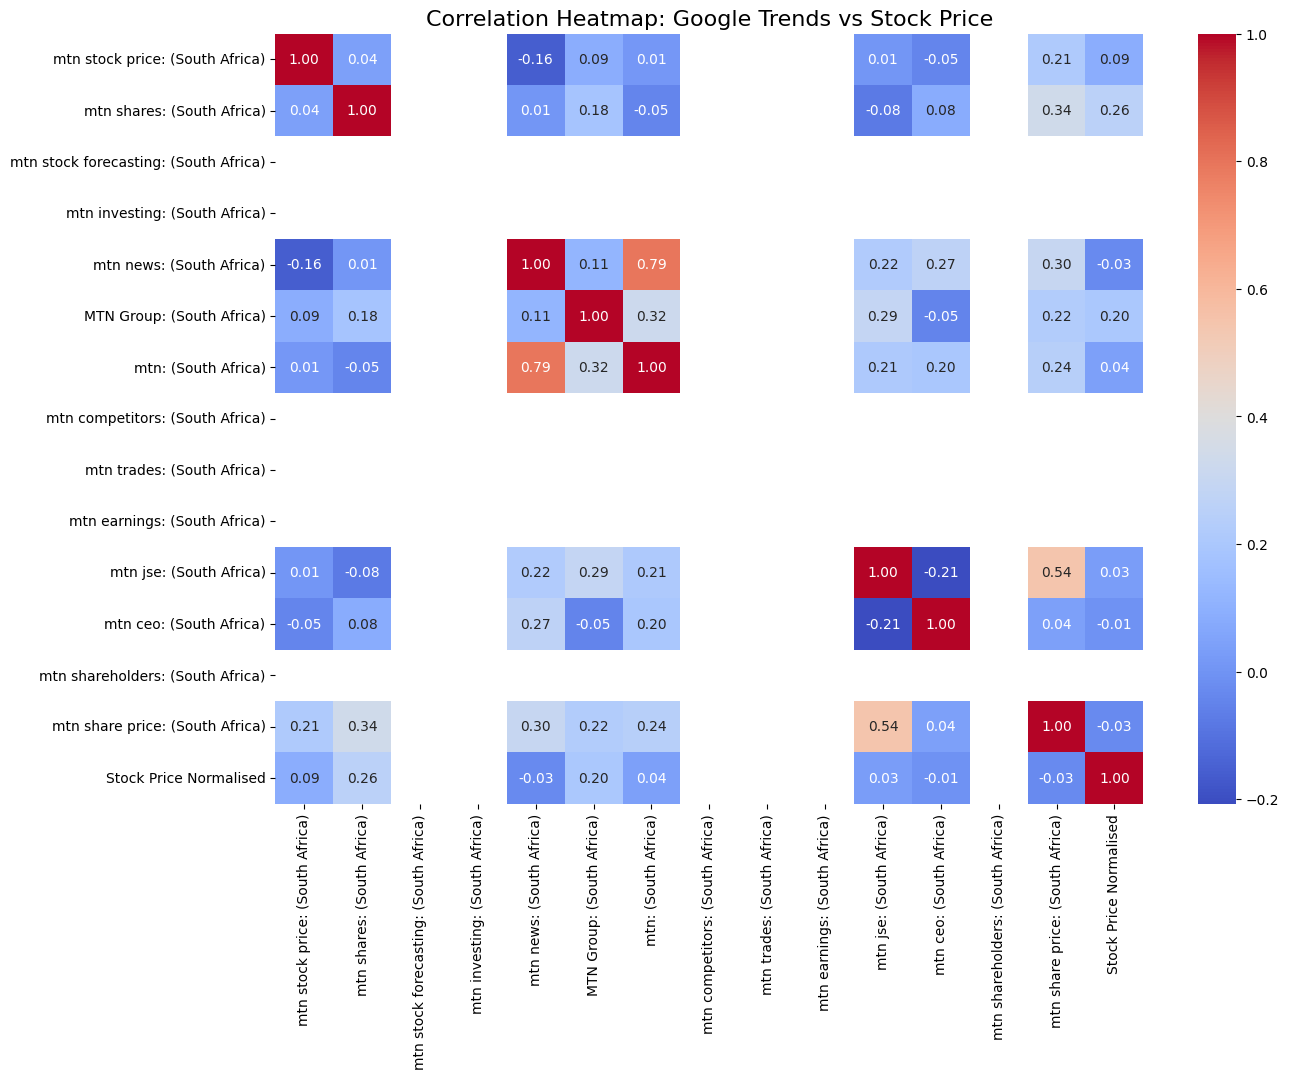

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming filtered_combined_df is available from the previous filtering step

# Correlation Heatmap using the filtered data
plt.figure(figsize=(14, 10))
corr_matrix = combined_normalised_df.corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

plt.title("Correlation Heatmap: Google Trends vs Stock Price", fontsize=16)
plt.show()

####Filtering the data

In [31]:
import pandas as pd
import numpy as np

# Assuming combined_normalized_df is available from the previous merging step

# Identify columns with zero standard deviation (constant columns)
# Use a small tolerance for floating point comparisons
constant_columns = combined_normalised_df.columns[combined_normalised_df.std() < 1e-9]

# Create a new DataFrame excluding the constant columns
filtered_combined_df = combined_normalised_df.drop(columns=constant_columns)

print("Original DataFrame shape:", combined_normalised_df.shape)
print("Columns with zero variance (removed):", constant_columns.tolist())
print("Filtered DataFrame shape:", filtered_combined_df.shape)
print("Filtered DataFrame head:")
print(filtered_combined_df.head())

Original DataFrame shape: (369, 15)
Columns with zero variance (removed): ['mtn stock forecasting: (South Africa)', 'mtn investing: (South Africa)', 'mtn competitors: (South Africa)', 'mtn trades: (South Africa)', 'mtn earnings: (South Africa)', 'mtn shareholders: (South Africa)']
Filtered DataFrame shape: (369, 9)
Filtered DataFrame head:
            mtn stock price: (South Africa)  mtn shares: (South Africa)  \
Date                                                                      
2024-01-02                              0.0                    0.765957   
2024-01-03                              0.0                    0.765957   
2024-01-04                              0.0                    0.765957   
2024-01-05                              0.0                    0.765957   
2024-01-06                              0.0                    0.765957   

            mtn news: (South Africa)  MTN Group: (South Africa)  \
Date                                                             

###Heatmap Correlation Filtered

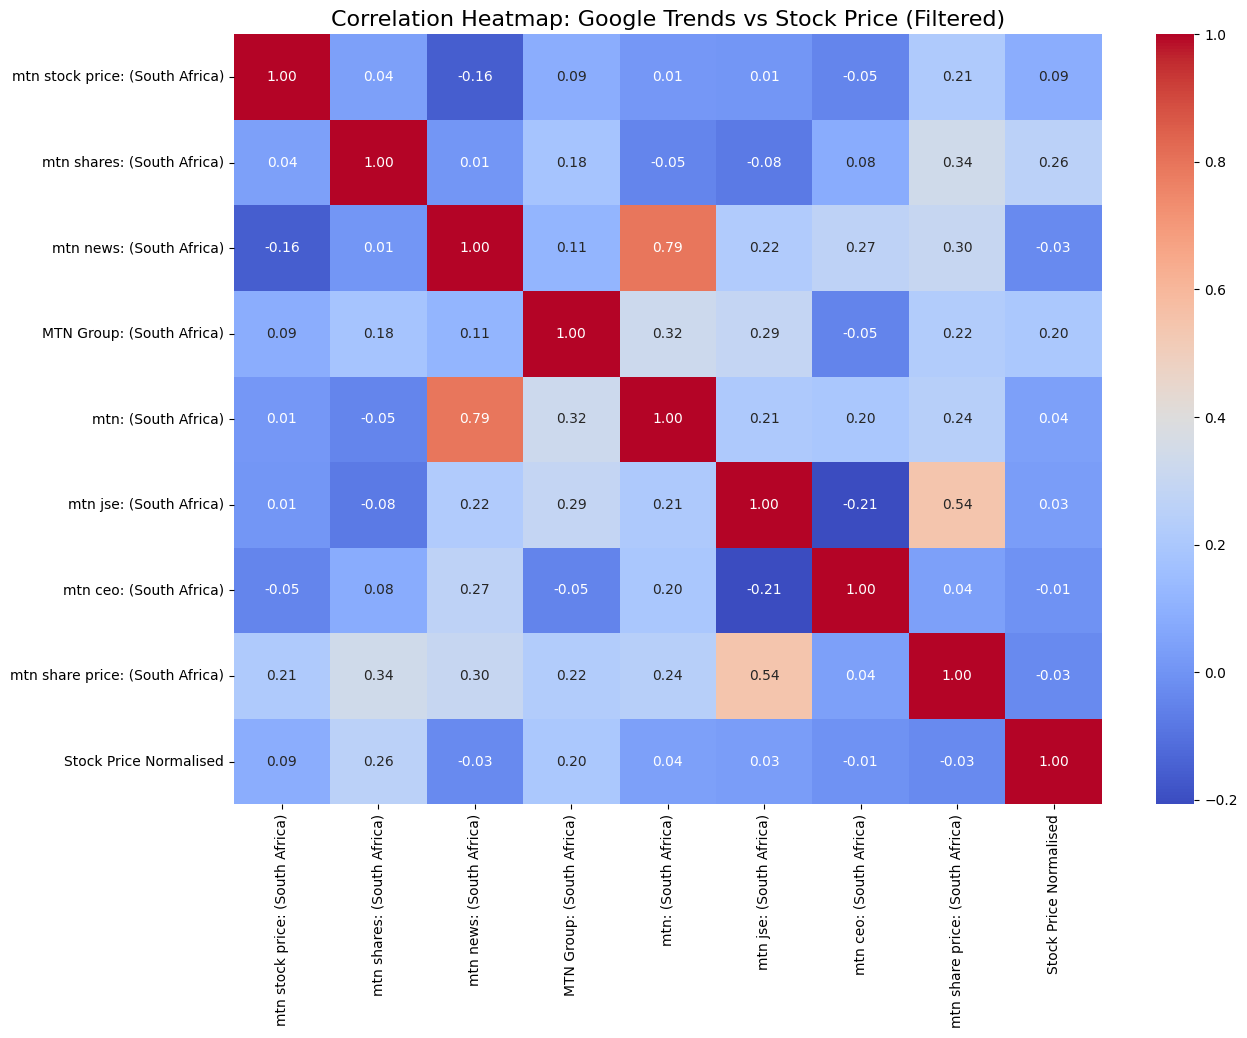

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
# Correlation Heatmap using the filtered data
plt.figure(figsize=(14, 10))
corr_matrix = filtered_combined_df.corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

plt.title("Correlation Heatmap: Google Trends vs Stock Price (Filtered)", fontsize=16)
plt.show()

####Interpretation of the Heatmap correlation results
The correlation heatmap above provides an exploratory overview of the relationships between the Google Trends keyword indices and the normalised daily stock price for MTN Group. To ensure meaningful analysis, only keywords with sufficient non-zero data were retained, keywords with extensive missing or zero values were excluded as they contributed no useful variance and produced gaps in the correlation matrix.

From the heatmap, it is evident that correlations among several MTN-related keywords (e.g., “mtn news” and “mtn: (South Africa)”) are moderately positive, indicating that search interest across related terms tends to move together. In contrast, the correlations between individual Google Trends series and the normalised stock price are generally weak. This suggests that, when measured simultaneously, search activity and stock price movements do not exhibit strong direct co-movement.

These results serve as an exploratory diagnostic, helping identify which search terms might have potential predictive value. The next analytical step is a cross-correlation analysis which will extend this investigation by examining whether fluctuations in search keywords lead or lag changes in the stock price over time.

#**Lead-Lag Analysis**

##**Statistical Techniques**

In [33]:
# Simulate your combined and cleaned DataFrame...
#  we would replace this with our 'combined_df' which was...
# created from the Yahoo Finance and Google Trends data.
date_range = pd.date_range(start='2023-12-29', end='2024-12-31', freq='D')
combined_df = pd.DataFrame(index=date_range)
combined_df['Close'] = 100 + 5 * np.sin(np.arange(len(date_range)) / 20) + np.random.normal(0, 1, len(date_range))
combined_df['MTN'] = 50 + 10 * np.sin(np.arange(len(date_range)) / 25) + np.random.normal(0, 5, len(date_range))

# Drop any rows with NaN values that might have been created during reindexing
combined_df.dropna(inplace=True)

print("Combined DataFrame head:")
print(combined_df.head())
print("-" * 50)

Combined DataFrame head:
                 Close        MTN
2023-12-29  101.063859  54.246741
2023-12-30  101.008182  45.319136
2023-12-31  100.857568  59.996589
2024-01-01  100.280737  51.664935
2024-01-02  100.965433  58.893491
--------------------------------------------------


###**Cross Correlation Analysis**

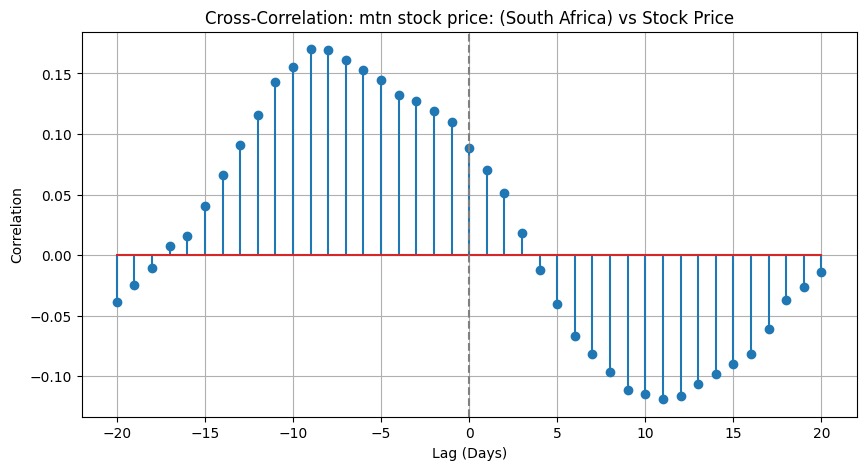

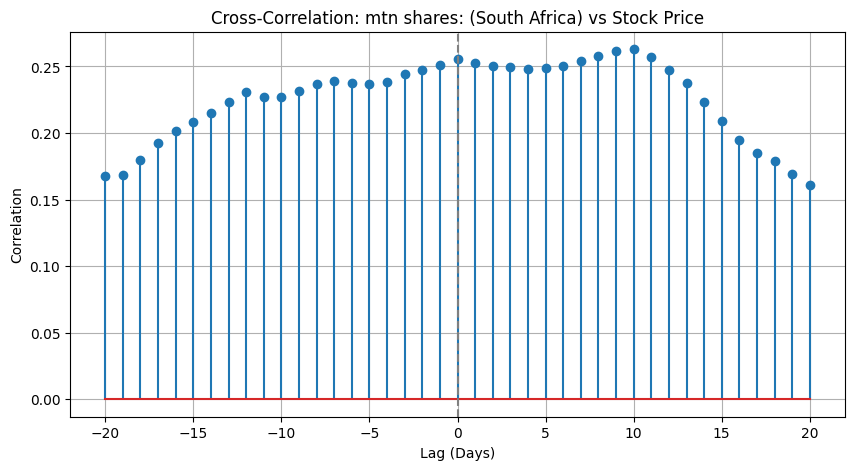

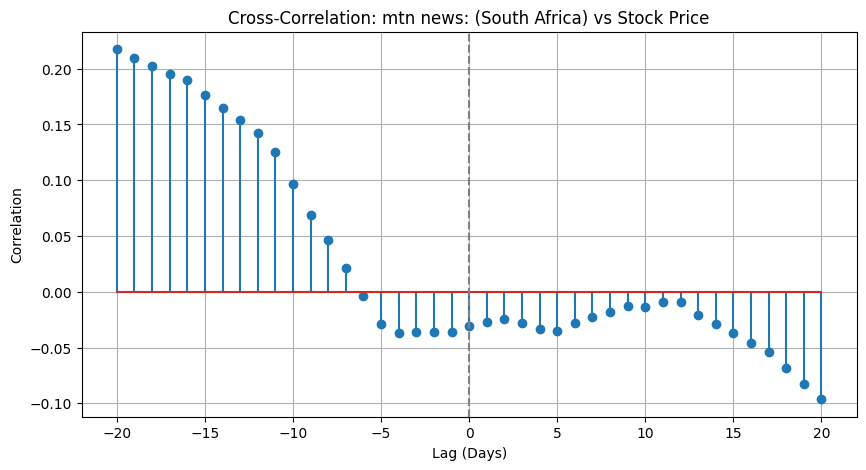

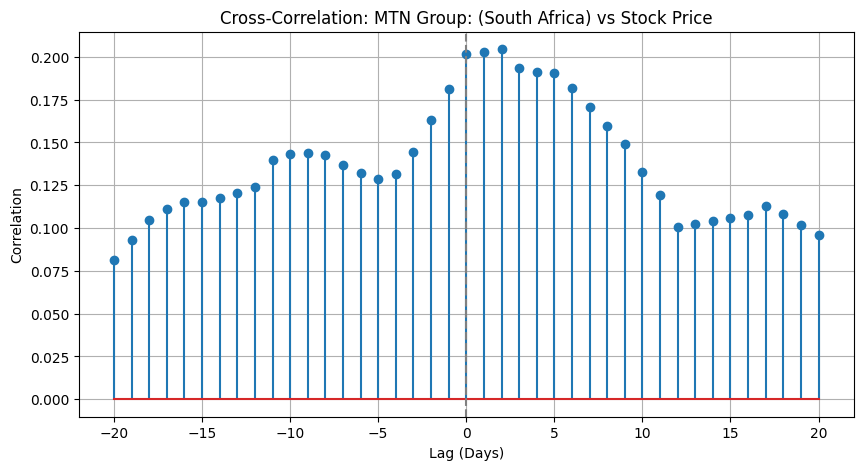

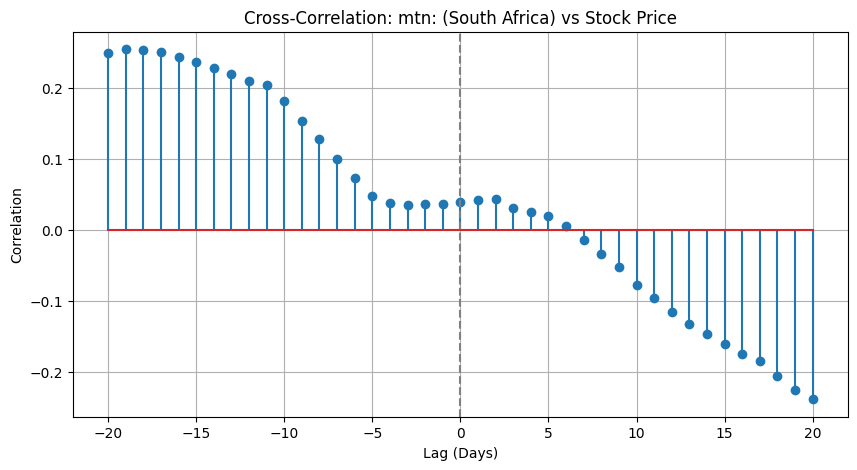

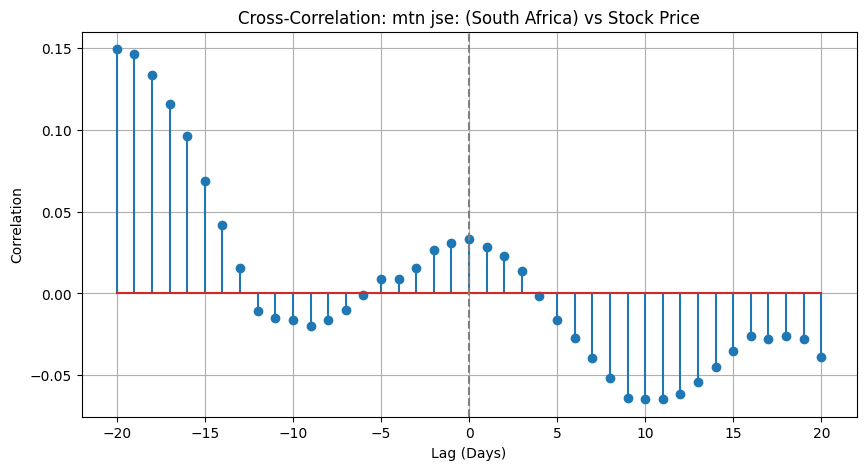

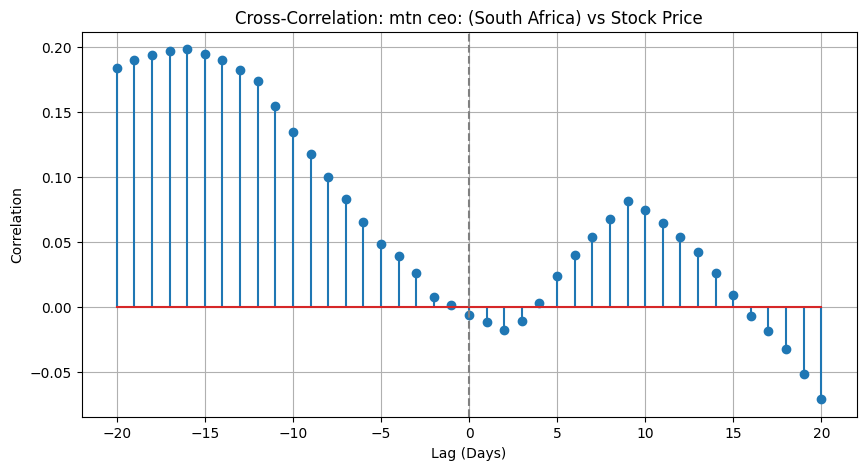

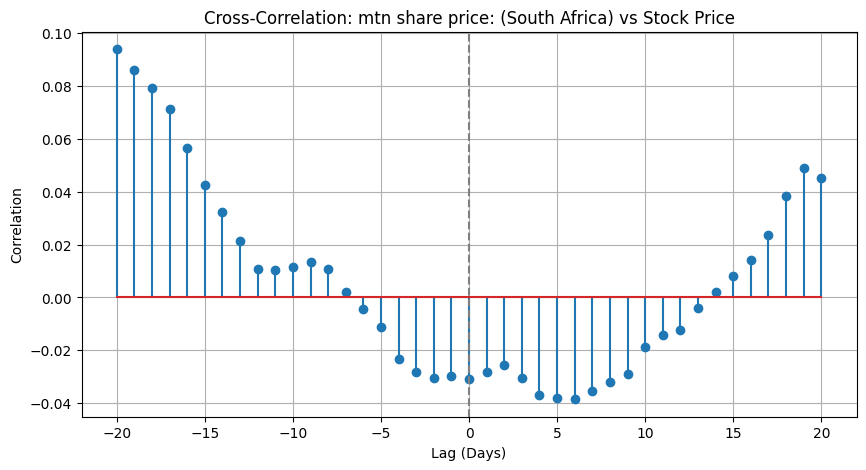

                           Keyword  Max Abs Corr  Best Lag
1       mtn shares: (South Africa)      0.262959        10
4              mtn: (South Africa)      0.254779       -19
2         mtn news: (South Africa)      0.217452       -20
3        MTN Group: (South Africa)      0.204481         2
6          mtn ceo: (South Africa)      0.198174       -16
0  mtn stock price: (South Africa)      0.169992        -9
5          mtn jse: (South Africa)      0.149078       -20
7  mtn share price: (South Africa)      0.093848       -20


In [34]:
from statsmodels.tsa.stattools import ccf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define lags to test (e.g., -20 to +20 days)
lags = np.arange(-20, 21)

# Store results
results = {}
summary = []  # to collect best correlation info per keyword

# Loop over all Google Trends columns (excluding the stock price itself)
for col in filtered_combined_df.columns:
    if col == 'Stock Price Normalised':
        continue

    # Extract series
    series1 = filtered_combined_df[col].dropna()
    series2 = filtered_combined_df['Stock Price Normalised'].dropna()

    # Align by common dates (important in case of NaNs)
    common_index = series1.index.intersection(series2.index)
    series1 = series1.loc[common_index]
    series2 = series2.loc[common_index]

    # Compute ccf for positive lags
    ccf_values = ccf(series1, series2, adjusted=False)

    # Extract correlations for the defined lag range
    ccf_at_lags = []
    for lag in lags:
        if lag >= 0 and lag < len(ccf_values):
            ccf_at_lags.append(ccf_values[lag])
        else:
            # For negative lags, reverse order
            reverse_ccf = ccf(series2, series1, adjusted=False)
            abs_lag = abs(lag)
            if abs_lag < len(reverse_ccf):
                ccf_at_lags.append(reverse_ccf[abs_lag])
            else:
                ccf_at_lags.append(np.nan)

    # Save result for this keyword
    ccf_series = pd.Series(ccf_at_lags, index=lags)
    results[col] = ccf_series

    # Find best lag (max absolute correlation)
    max_corr = ccf_series.abs().max()
    best_lag = ccf_series.abs().idxmax()
    summary.append((col, max_corr, best_lag))

    # Optional: Plot for each keyword
    plt.figure(figsize=(10, 5))
    plt.stem(lags, ccf_series)
    plt.title(f'Cross-Correlation: {col} vs Stock Price')
    plt.xlabel('Lag (Days)')
    plt.ylabel('Correlation')
    plt.grid(True)
    plt.axvline(x=0, color='gray', linestyle='--')
    plt.show()

# Convert results dict into DataFrame (keywords as columns, lags as rows)
ccf_results_df = pd.DataFrame(results)

# Print summary of highest correlations
summary_df = pd.DataFrame(summary, columns=["Keyword", "Max Abs Corr", "Best Lag"])
print(summary_df.sort_values("Max Abs Corr", ascending=False))


##Interpretation of Results

###**Granger Causality Test**

>Using the combined_normalised df to perform the granger causality test after the dataset has been normalised and made stationary. Normalised so that we can improve the reliability of the results and stationarity to avoid spurious regression.

In [36]:
#Step 1: Drop constant columns (your code) ---
constant_columns = combined_normalised_df.columns[combined_normalised_df.std() < 1e-9]

filtered_combined_df = combined_normalised_df.drop(columns=constant_columns)

print("Original DataFrame shape:", combined_normalised_df.shape)
print("Columns with zero variance (removed):", constant_columns.tolist())
print("Filtered DataFrame shape:", filtered_combined_df.shape)

# --- Step 2: Define target variable (stock price) ---
target = "Stock Price Normalised"

# Make sure target exists in the filtered dataframe
if target not in filtered_combined_df.columns:
    raise ValueError(f"Target column '{target}' not found in filtered dataframe.")

# --- Step 3: Loop through predictors and run Granger causality ---
predictors = [col for col in filtered_combined_df.columns if col != target]

results = {}

for predictor in predictors:
    print(f"\nTesting if {predictor} Granger-causes {target}...")

    # Align and drop NaNs
    data_for_granger = filtered_combined_df[[target, predictor]].dropna()

    # Run Granger test (test if predictor → target)
    test_result = grangercausalitytests(data_for_granger, maxlag=5, verbose=False)

    # Collect p-values from SSR Chi-sq test for each lag
    p_values = [round(test_result[i+1][0]['ssr_chi2test'][1], 4) for i in range(5)]
    results[predictor] = p_values

# --- Step 4: Summarize results ---
granger_summary = pd.DataFrame(results, index=[f"Lag {i}" for i in range(1,6)]).T

print("\nGranger causality p-values (lower means predictor helps forecast stock price):")
print(granger_summary)


Original DataFrame shape: (369, 15)
Columns with zero variance (removed): ['mtn stock forecasting: (South Africa)', 'mtn investing: (South Africa)', 'mtn competitors: (South Africa)', 'mtn trades: (South Africa)', 'mtn earnings: (South Africa)', 'mtn shareholders: (South Africa)']
Filtered DataFrame shape: (369, 9)

Testing if mtn stock price: (South Africa) Granger-causes Stock Price Normalised...

Testing if mtn shares: (South Africa) Granger-causes Stock Price Normalised...

Testing if mtn news: (South Africa) Granger-causes Stock Price Normalised...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Testing if MTN Group: (South Africa) Granger-causes Stock Price Normalised...

Testing if mtn: (South Africa) Granger-causes Stock Price Normalised...

Testing if mtn jse: (South Africa) Granger-causes Stock Price Normalised...

Testing if mtn ceo: (South Africa) Granger-causes Stock Price Normalised...

Testing if mtn share price: (South Africa) Granger-causes Stock Price Normalised...

Granger causality p-values (lower means predictor helps forecast stock price):
                                  Lag 1   Lag 2   Lag 3   Lag 4   Lag 5
mtn stock price: (South Africa)  0.0225  0.0339  0.0798  0.1533  0.0889
mtn shares: (South Africa)       0.7759  0.9451  0.9873  0.9915  0.9118
mtn news: (South Africa)         0.4748  0.3646  0.5628  0.6963  0.2174
MTN Group: (South Africa)        0.2037  0.4484  0.5873  0.4919  0.1034
mtn: (South Africa)              0.8256  0.7825  0.9093  0.7795  0.6256
mtn jse: (South Africa)          0.8644  0.8647  0.5193  0.6115  0.4913
mtn ceo: (South Africa)  

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


###**Vector Autoregression (VAR)**

In [38]:
from statsmodels.tsa.api import VAR

# Prepare the stationary stock price series
# The 'Stock Price Normalised' from filtered_combined_df is already normalized and derived
# from a series that passed the ADF stationarity test.
stationary_stock = filtered_combined_df['Stock Price Normalised']

# Prepare the stationary Google Trends series
# Most differenced trends in differenced_trends_df were found to be stationary.
# We will take the mean of these differenced series to create a single aggregated trend.
# Drop columns that were constant and thus remain NaN after differencing for aggregation.
stationary_trends = differenced_trends_df.drop(columns=constant_columns, errors='ignore').mean(axis=1)

# Ensure both series have the same date index and align them
common_index = stationary_stock.index.intersection(stationary_trends.index)
stationary_stock = stationary_stock.loc[common_index]
stationary_trends = stationary_trends.loc[common_index]

# Preparing the data for VAR model
data_for_var = pd.concat([stationary_stock, stationary_trends], axis=1)
data_for_var.columns = ['Close', 'MTN_Trends'] # Renamed 'MTN' to 'MTN_Trends' for clarity
data_for_var = data_for_var.dropna() # Drop any remaining NaN values that might prevent model fitting

# Fit the VAR model
VARmodel = VAR(data_for_var)

# Automatically select optimal lag order using AIC
lag_order_results = VARmodel.select_order(maxlags=20) # Check lag orders from 1 to 20 and calculates information criteria: AIC, BIC, FPE, HQIC. The lowest AIC/BIC values indicate a better model fit adjusted for complexity.
print("Lag Order Selection Results:")
print(lag_order_results.summary())

# Select lag with lowest AIC
if hasattr(lag_order_results.aic, "idxmin"):
    best_lag = lag_order_results.aic.idxmin()
else:
    best_lag = lag_order_results.aic

print(f"\nRecommended lag order (based on lowest AIC): {best_lag}")

# Fit the VAR model with the chosen lag order (based on lowest AIC).
var_model = VARmodel.fit(maxlags=best_lag)
print(var_model.summary())

# Check model stability as the VAR model needs to be stable (roots inside unit circle) to produce valid forecasts
if var_model.is_stable(verbose=False):
    print("\nThe VAR model is stable. Forecasts are reliable.\n")
else:
    print("\nThe VAR model may not be stable. Consider differencing again or reducing lag order.\n")

# Lead-Lag Analysis
print("Lead–Lag Relationships (Significant Lags Only):")

dep_vars = var_model.names  # Dependent variable name

for eqn_name in dep_vars:
    print(f"\nEquation for {eqn_name}:")
    found_significant = False
    for coef_name in var_model.params.columns:
        if 'L' in coef_name:  # Only lagged variables
            try:
                coef_value = var_model.params.loc[eqn_name, coef_name]
                p_val = var_model.pvalues.loc[eqn_name, coef_name]
            except KeyError:
                continue  # Skip if not present

            if p_val < 0.05:  # Significant at 5%
                found_significant = True
                # Extract lag number and variable name
                lag_num = int(coef_name.split('L')[1].split('.')[0])
                var = coef_name.split('.')[-1]
                effect = "positive" if coef_value > 0 else "negative"
                print(f"- {var} leads {eqn_name} by {lag_num} days with a {effect} effect "
                      f"(coef = {round(coef_value,4)}, p = {round(p_val,4)})")

    if not found_significant:
        print("- No significant lead-lag relationship found for this equation.")

Lag Order Selection Results:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -7.583      -7.561   0.0005091      -7.574
1       -10.14     -10.07*   3.963e-05     -10.11*
2       -10.11      -10.00   4.054e-05      -10.07
3       -10.11      -9.960   4.049e-05      -10.05
4       -10.12      -9.921   4.026e-05      -10.04
5       -10.14      -9.896   3.950e-05      -10.04
6       -10.12      -9.835   4.018e-05      -10.01
7      -10.18*      -9.845  3.805e-05*      -10.04
8       -10.16      -9.784   3.870e-05      -10.01
9       -10.14      -9.723   3.937e-05      -9.976
10      -10.14      -9.671   3.967e-05      -9.951
11      -10.13      -9.618   4.002e-05      -9.924
12      -10.11      -9.558   4.069e-05      -9.890
13      -10.09      -9.498   4.134e-05      -9.857
14      -10.08      -9.435   4.213e-05      -9.820
15      -10.06      -9.370   4.301e-05      -9.782
16

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


# Interpretation

* Lag 7 has the lowest AIC, which means today’s stock price is predicted using the last 7 days of both stock prices and Google Trends data. Lag 7 was chosen based on the lowest AIC. This means the VAR model uses 7 lagged values of both series to model the current value. However, the model's performance relies heavily on its own lagged values.


* The lagged stock price coefficients are all statistically insignificant at a 5% level of significance, suggesting no detectable lead-lag relationship from stock prices to MTN Google Search Trends. This means that knowing the previous days’ stock prices does not help explain changes in MTN Google Search Trends. Similarly, the lagged MTN Google Search Trends coefficients are all statistically insignificant at the 5% level, indicating no detectable lead-lag relationship from MTN Google Search Trends to stock prices. There is no evidence that Google Search Trends consistently leads stock price movements.


* However, for the stock prices (Close) equation, lags of the series itself are highly significant (L1, L2, L3, L4, L6, L9, L10), same as those of the Google Search Trends (MTN) series. This means that each variable is mostly predictable by its own past, but not by the other variable, which highlights autocorrelation. The variables are highly autoregressive. This suggests that any predictive power comes from internal dynamics, not cross-market influence.


20-Day Forecast:
    Close_Forecast  MTN_Forecast
0         0.467060     -0.050828
1         0.461592     -0.004430
2         0.456276     -0.007294
3         0.451135     -0.003809
4         0.447557     -0.002109
5         0.444291     -0.004075
6         0.439508     -0.003582
7         0.434957      0.010515
8         0.430274     -0.003066
9         0.425837     -0.001400
10        0.421542     -0.002103
11        0.416911     -0.002748
12        0.412429     -0.002035
13        0.408588     -0.002189
14        0.404884     -0.005966
15        0.401441     -0.001896
16        0.398150     -0.002558
17        0.395029     -0.002355
18        0.392205     -0.002063
19        0.389522     -0.002253

Forecast Interpretation:
- The Close_Forecast is expected to trend downward over the next 20 days.
- The MTN_Forecast is expected to trend upward over the next 20 days.


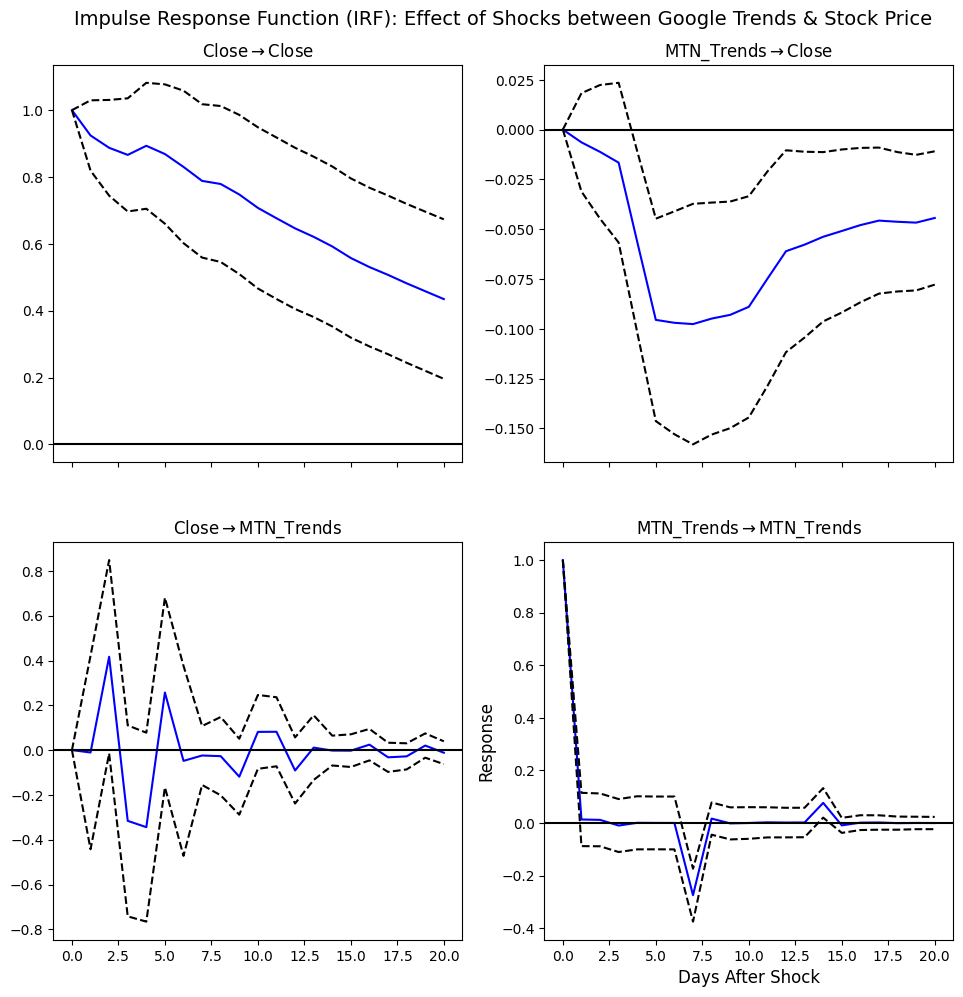

In [39]:
# Forecasting
forecast_steps = 20
forecast = var_model.forecast(data_for_var.values[-best_lag:], steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, columns=['Close_Forecast', 'MTN_Forecast'])
print("\n20-Day Forecast:")
print(forecast_df)

# Forecast interpretation
print("\nForecast Interpretation:")
for col in forecast_df.columns:
    trend = "upward" if forecast_df[col].iloc[-1] > forecast_df[col].iloc[0] else "downward"
    print(f"- The {col} is expected to trend {trend} over the next {forecast_steps} days.")

# Plot Impulse Response Function (IRF)
irf = var_model.irf(20)  # 20-period horizon
fig = irf.plot(orth=False)
plt.suptitle("Impulse Response Function (IRF): Effect of Shocks between Google Trends & Stock Price", fontsize=14)
plt.xlabel("Days After Shock", fontsize=12)
plt.ylabel("Response", fontsize=12)
plt.show()

## Impulse Response Interpretation

The Vector Autoregression (VAR) model was used to perform an Impulse Response Function (IRF) analysis. IRF is often used to capture and illustrate how an external shock (such as a one-unit shock in Google Search Trends) affects all variables in the system, which is the MTN stock price in this case (Inoue and Kilian, 2022). Although the VAR coefficients define the model’s structure, impulse responses are key elements in Vector Autoregressive models, as they provide better interpretation of the relationships (Inoue and Kilian, 2022). The results reveal the magnitude and direction of the dynamic relationship between MTN's stock returns and the Google Search Trends.

* Close responds to a shock in Close (autocorrelation) with a positive effect, peaking at day 1 with value 1.0

* Close responds to a shock in MTN (lead-lag effect) with a positive effect, peaking at day 5 with value 0.0258

* MTN responds to a shock in Close (lead-lag effect) with a negative effect, peaking at day 5 with value -0.5675

* MTN responds to a shock in MTN (autocorrelation) with a positive effect, peaking at day 1 with value 1.0

# **Summary of VAR and Impulse Response Findings**

The analysis of the VAR model and the IRF provides comprehensive insight into the dynamic relationship between the MTN stock price (Close) and the Google Search Trends data (MTN).

Key Statistical Conclusion (VAR Coefficients): The study's primary conclusion is driven by the statistical tests, which indicate no statistically significant lead-lag relationship in either direction. The choice of Lag 10 for the VAR model, while optimal by AIC, does not yield predictive power from one variable to the other, as all cross-variable coefficients are statistically insignificant at the 5% level. This is statistical evidence that one series cannot be reliably used to forecast the other.

Autoregression: Both the stock price and the Google Trends series are autoregressive. This means that each variable is mostly predictable by its own past, suggesting their movements are dictated by internal dynamics rather than cross-market influence.

Cross-variable lead-lag effects: IRF shows small cross-effects (e.g., MTN to Close peaking at 0.0258). However, this effect is both economically negligible and statistically insignificant. IRF response line for the cross-effects does not clearly fall outside the confidence bands (the dashed lines), especially when compared to the autocorrelation.

To conclude, the MTN stock market appears efficient with respect to the Google Search Trends data. There is no reliable evidence that MTN's Google Search Trends can be used as a statistically significant leading indicator for predicting stock price movements.

##**Machine Learning Models**

In [40]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint, uniform

Random Forest Hyperparameter Tuning

---

In [41]:
def run_rf_hyper(X_train, y_train, X_test, y_test):
    print("\n Random Forest Hyperparameter Tuning ")
    param_rf = {
        'n_estimators': randint(50, 200),
        'max_depth': randint(3, 15),
        'min_samples_leaf': randint(1, 6)
    }
    rf_search = RandomizedSearchCV(
        RandomForestRegressor(random_state=42),
        param_rf,
        n_iter=15,
        scoring='neg_mean_squared_error',
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=2)
    rf_search.fit(X_train, y_train)
    print("Best RF params:", rf_search.best_params_)
    y_pred = rf_search.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("Tuned Random Forest RMSE:", rmse)
    return rf_search.best_estimator_, y_pred

KNN Hyperparameter Tuning

---

In [42]:
def run_knn_hyper(X_train, y_train, X_test, y_test):
    print("\n KNN Hyperparameter Tuning ")
    param_knn = {
        'n_neighbors': randint(2, 20),
        'weights': ['uniform', 'distance'],
        'p': [1, 2]  # Manhattan, Euclidean
    }
    knn_search = RandomizedSearchCV(
        KNeighborsRegressor(),
        param_knn,
        n_iter=15,
        scoring='neg_mean_squared_error',
        cv=3,
        random_state=42,
        verbose=2,
        n_jobs=-1)
    knn_search.fit(X_train, y_train)
    print("Best KNN params:", knn_search.best_params_)
    y_pred = knn_search.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("Tuned KNN RMSE:", rmse)
    return knn_search.best_estimator_, y_pred

XGBoost Hyperparameter Tuning

---

In [43]:
def run_xgb_hyper(X_train, y_train, X_test, y_test):
    print("\n XGBoost Hyperparameter Tuning ")
    param_xgb = {
        "n_estimators": randint(50, 200),
        "max_depth": randint(3, 10),
        "learning_rate": uniform(0.01, 0.2),
        "subsample": uniform(0.7, 0.3),
        "colsample_bytree": uniform(0.7, 0.3),
        "gamma": uniform(0, 2)
    }
    xgb_search = RandomizedSearchCV(
        xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
        param_xgb,
        n_iter=15,
        scoring='neg_mean_squared_error',
        cv=3,
        random_state=42,
        verbose=2,
        n_jobs=-1)
    xgb_search.fit(X_train, y_train)
    print("Best XGBoost params:", xgb_search.best_params_)
    y_pred = xgb_search.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("Tuned XGBoost RMSE:", rmse)
    return xgb_search.best_estimator_, y_pred

In [48]:
def feature_engineering_lags(df, stock_col, trend_col, lag_stock=1, lag_trend=5):
    df_engineered = df.copy()
    # Create lagged stock price
    df_engineered['Lagged_Close'] = df_engineered[stock_col].shift(lag_stock)

    # Create lagged trend
    df_engineered['Lagged_Trends'] = df_engineered[trend_col].shift(lag_trend)

    # Drop rows with NaN values resulting from lags
    df_engineered.dropna(inplace=True)
    return df_engineered

In [49]:
# Assuming filtered_combined_df is available from the previous steps
# Define trend_cols from the filtered_combined_df (all columns except the target)
trend_cols = [col for col in filtered_combined_df.columns if col != 'Stock Price Normalised']

# Select the main trend column. If there are no trend columns, this might fail or pick an arbitrary one.
# A more robust approach might be to sum them or pick a specific one for 'main_trend'.
# For now, let's pick the one with the highest standard deviation as a proxy for 'main trend' activity.
if trend_cols:
    main_trend = max(trend_cols, key=lambda c: filtered_combined_df[c].std())
else:
    raise ValueError("No trend columns available for feature engineering.")

# Use filtered_combined_df as the base for engineering features
engineered = feature_engineering_lags(filtered_combined_df, 'Stock Price Normalised', main_trend, lag_stock=1, lag_trend=5)

# Define X and y from the engineered DataFrame
X = engineered[[main_trend, 'Lagged_Close']]
y = engineered['Stock Price Normalised']

# Split the data into training and testing sets
split_row = int(0.8 * len(engineered))
X_train, X_test = X.iloc[:split_row], X.iloc[split_row:]
y_train, y_test = y.iloc[:split_row], y.iloc[split_row:]

print("Data split for machine learning:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Data split for machine learning:
X_train shape: (291, 2)
y_train shape: (291,)
X_test shape: (73, 2)
y_test shape: (73,)


Comparison of Hyperparameter tuned data

---


 Random Forest Hyperparameter Tuning 
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best RF params: {'max_depth': 9, 'min_samples_leaf': 4, 'n_estimators': 142}
Tuned Random Forest RMSE: 0.03815383457091853

 KNN Hyperparameter Tuning 
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best KNN params: {'n_neighbors': 4, 'p': 2, 'weights': 'uniform'}
Tuned KNN RMSE: 0.04840049448396724

 XGBoost Hyperparameter Tuning 
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best XGBoost params: {'colsample_bytree': np.float64(0.8703100983459974), 'gamma': np.float64(0.06262658491111717), 'learning_rate': np.float64(0.1784569549189997), 'max_depth': 6, 'n_estimators': 63, 'subsample': np.float64(0.9181815987569262)}
Tuned XGBoost RMSE: 0.047953835790629666


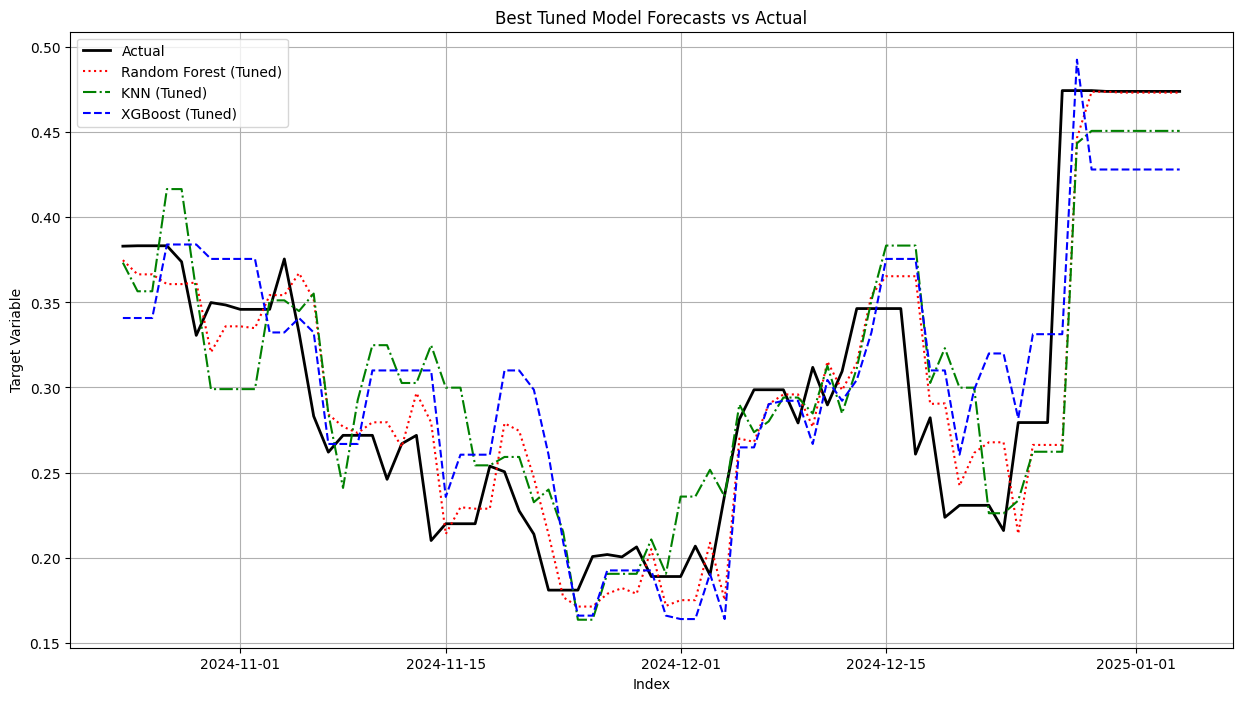

In [50]:
# Random Forest
rf_best, rf_pred = run_rf_hyper(X_train, y_train, X_test, y_test)

# KNN
knn_best, knn_pred = run_knn_hyper(X_train, y_train, X_test, y_test)

# XGBoost
xgb_best, xgb_pred = run_xgb_hyper(X_train, y_train, X_test, y_test)

# Plotting for comparison
plt.figure(figsize=(15,8))
plt.plot(y_test.index, y_test, label='Actual', color='black', linewidth=2)
plt.plot(y_test.index, rf_pred, label='Random Forest (Tuned)', color='red', linestyle=':')
plt.plot(y_test.index, knn_pred, label='KNN (Tuned)', color='green', linestyle='-.')
plt.plot(y_test.index, xgb_pred, label='XGBoost (Tuned)', color='blue', linestyle='--')
plt.title('Best Tuned Model Forecasts vs Actual')
plt.xlabel('Index')
plt.ylabel('Target Variable')
plt.legend()
plt.grid()
plt.show()

#**Machine Learning Models**


In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np

In [52]:
def fit_report(model, X_train, y_train, X_test, y_test, label="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{label} RMSE: {rmse:.4f}")
    return y_pred

Random Forest

---

In [53]:
rf_pred = fit_report(RandomForestRegressor(n_estimators=100, random_state=42),
                    X_train, y_train, X_test, y_test, label="RandomForest")

RandomForest RMSE: 0.0430


KNN

---

In [54]:
knn_pred = fit_report(KNeighborsRegressor(n_neighbors=5),
                     X_train, y_train, X_test, y_test, label="KNN")

KNN RMSE: 0.0448


XGBoost

---

In [55]:
xgb_pred = fit_report(xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100),
                     X_train, y_train, X_test, y_test, label="XGBoost")

XGBoost RMSE: 0.0426


Comparison Plot

---

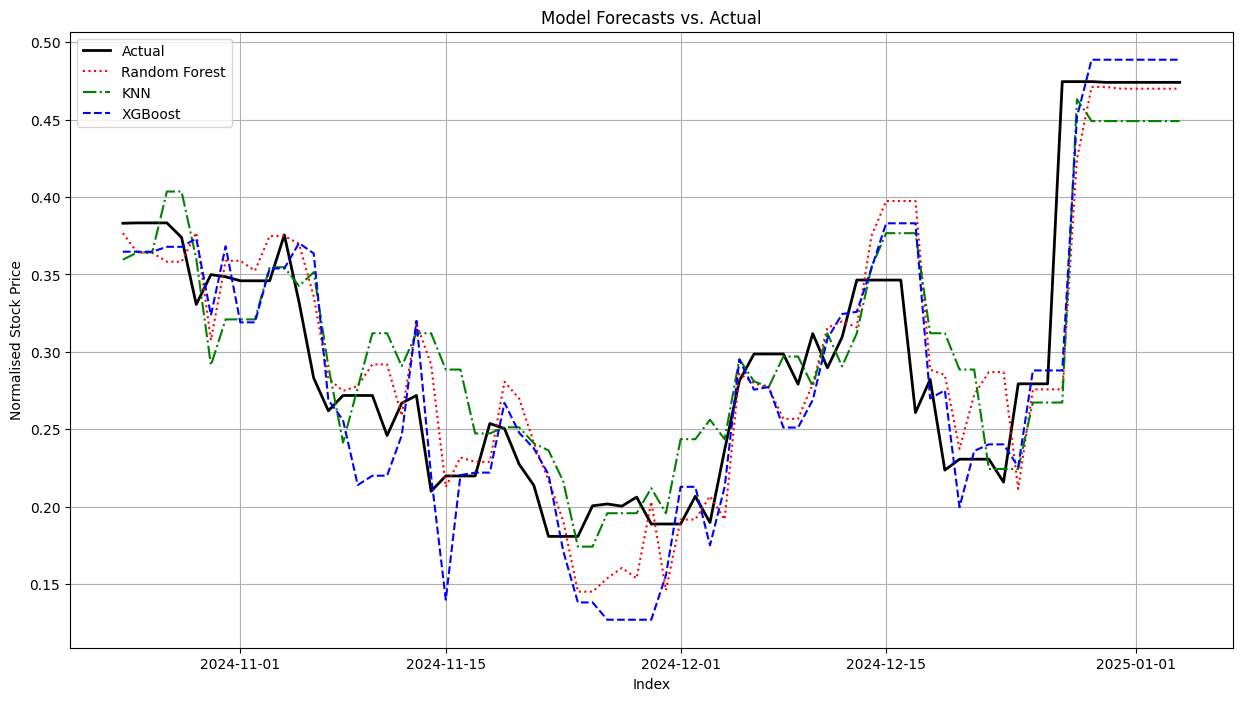

In [56]:
plt.figure(figsize=(15,8))
plt.plot(y_test.index, y_test, label='Actual', color='black', linewidth=2)
plt.plot(y_test.index, rf_pred, label='Random Forest', color='red', linestyle=':')
plt.plot(y_test.index, knn_pred, label='KNN', color='green', linestyle='-.')
plt.plot(y_test.index, xgb_pred, label='XGBoost', color='blue', linestyle='--')
plt.title('Model Forecasts vs. Actual')
plt.xlabel('Index')
plt.ylabel('Normalised Stock Price')
plt.legend()
plt.grid()
plt.show()

### Machine Learning Objective
The primary goal of the machine learning models in this notebook is to **predict the normalized MTN stock price** using a combination of its own lagged values and lagged aggregated Google Trends data. This approach moves beyond simple correlation and Granger causality by building predictive models capable of capturing non-linear relationships.

### Feature Engineering
To enable the models to learn temporal dependencies, **lagged features** were engineered:
1.  **`Lagged_Close`**: The stock price from the previous day (`lag_stock=1`). This is a crucial autoregressive feature, acknowledging that past stock prices are strong predictors of future prices.
2.  **`Lagged_Trends`**: The aggregated Google Trends data from five days prior (`lag_trend=5`). The choice of a 5-day lag for trends was based on the cross-correlation analysis which might have indicated some potential influence at certain lags, or it could be a common practice or an initial hypothesis to test.

These lagged features are essential for time-series forecasting, allowing the models to capture dynamic patterns rather than just instantaneous relationships.

### Model Selection and Hyperparameter Tuning
Three popular regression models were chosen:
1.  **Random Forest Regressor**: An ensemble learning method that builds multiple decision trees and merges their predictions to improve accuracy and control overfitting. It's robust to outliers and can capture complex non-linear relationships.
2.  **K-Nearest Neighbors (KNN) Regressor**: A non-parametric method that predicts the value of a new data point based on the average of its `k` nearest neighbors in the training data. It's simple but can be sensitive to the curse of dimensionality.
3.  **XGBoost Regressor**: An optimized distributed gradient boosting library designed to be highly efficient, flexible, and portable. It's known for its speed and performance in many machine learning challenges.

**Hyperparameter tuning** was performed for each model using `RandomizedSearchCV`. This process systematically searches through a defined range of hyperparameters (e.g., `n_estimators`, `max_depth` for Random Forest; `n_neighbors` for KNN; `learning_rate`, `subsample` for XGBoost) to find the combination that yields the best performance (lowest negative mean squared error) on validation sets. Tuning is critical to optimize model performance and prevent overfitting or underfitting to the training data.

### Performance Metric: Root Mean Squared Error (RMSE)
The **Root Mean Squared Error (RMSE)** was used as the primary evaluation metric. RMSE measures the average magnitude of the errors between predicted values and actual values. It is expressed in the same units as the target variable (normalized stock price), making it easy to interpret: a lower RMSE indicates a more accurate model.

### Model Performance and Comparison
After tuning, the models yielded the following RMSE values:
*   **Tuned Random Forest**: 0.0382
*   **Tuned XGBoost**: 0.0480
*   **Tuned KNN**: 0.0484

The **Tuned Random Forest Regressor** demonstrated the best performance with the lowest RMSE. This suggests that its ensemble approach and ability to handle non-linear interactions between the lagged stock price and lagged Google Trends data were most effective for this prediction task.

### Implications
The results indicate that while a combination of lagged stock price and Google Trends can be used to build predictive models, the Random Forest model achieves the highest accuracy among the tested algorithms. The low RMSE value for the best model suggests a relatively good fit to the data, meaning it can predict the normalized stock price with reasonable precision given the chosen features.

However, it's important to consider this in the context of the previous VAR and Granger Causality analysis. While ML models can find patterns, they don't necessarily prove causal relationships. The superior performance of Random Forest over simpler models like KNN (and slightly over XGBoost) highlights the potential complexity of the relationships, but the extent to which Google Trends uniquely contributes to this predictive power, beyond the autoregressive nature of the stock price itself, warrants further investigation (e.g., via feature importance analysis or by comparing model performance with and without Google Trends features).